# <center>Previsão de Consumo de Combustível

 Legendas:
   * <code style="color:green">Teoria/Instruções</code>
   * <code style="color:purple">Comentários</code>
   * <code style="color:red">Dúvidas a serem esclarecidas</code>

# <center>IMPORTAÇÕES INICIAIS

## <center>Importando Bibliotecas

In [1687]:
# Bibliotecas

import pandas as pd                                                           # Biblioteca para manipulação e análise de dados
import numpy as np                                                            # Biblioteca para cálculos numéricos e operações com arrays
import matplotlib.pyplot as plt                                               # Biblioteca para criação de gráficos e visualizações
import matplotlib.ticker as mticker                                           # Biblioteca para formatação de eixos em gráficos
import plotly.express as px                                                   # Biblioteca para visualizações interativas
import seaborn as sns                                                         # Biblioteca para visualizações estatísticas avançadas

from tabulate import tabulate                                                 # Biblioteca para exibição formatada de tabelas no terminal

import missingno as msno                                                      # Biblioteca para visualização de valores ausentes
import os                                                                     # Biblioteca para interações com o sistema operacional

from sklearn.linear_model import LinearRegression                             # Modelo de regressão linear do scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score  # Métricas para avaliação de modelos de regressão
from sklearn.model_selection import train_test_split, cross_val_score         # Métodos para divisão de dados e validação cruzada
from sklearn.feature_selection import SequentialFeatureSelector               # Método de seleção sequencial de variáveis
from sklearn.feature_selection import RFE                                     # Método Recursive Feature Elimination para seleção de variáveis
from sklearn.ensemble import RandomForestRegressor                            # Modelo de regressão baseado em Floresta Aleatória
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import PowerTransformer                            # Função para a transformação boxcox

import scipy.stats as stats                                                   # Biblioteca para estatísticas e testes estatísticos
from scipy.stats import shapiro                                               # Teste de normalidade de Shapiro-Wilk
from scipy.stats               import boxcox                                  # Transformação Box-Cox
from scipy.special             import inv_boxcox                              # Inversa da transformação Box-Cox
from scipy.stats import kstest                                                # Teste de Kolmogorov-Smirnov para comparação de distribuições

import pylab                                                                  # Biblioteca auxiliar para visualizações estatísticas, como QQ-plots

import inflection                                                             # Biblioteca para manipulação de strings, especialmente para conversão entre formatos de nomenclatura
from unidecode import unidecode                                               # Biblioteca para remover acentuação de strings

import statsmodels.formula.api as smf                                         # Biblioteca para modelagem estatística baseada em fórmulas
import statsmodels.api as sm                                                  # Biblioteca para análise estatística e econométrica
from statsmodels.stats.diagnostic import het_breuschpagan                     # Teste de heterocedasticidade de Breusch-Pagan
from statsmodels.stats.outliers_influence import variance_inflation_factor    # Cálculo do fator de inflação da variância (VIF) para detectar multicolinearidade


## <center>Definindo Funções

### Funções Gerais

Descrição, EDA, Modeling

In [1688]:
# DATA DESCRIPTION ---------------------------------------------------------------------------------------------

def data_description(data):
    """
    Função para exibir um resumo do dataset, incluindo:
    - Dimensões do dataset
    - Tipos de dados
    - Quantidade de valores ausentes
    - Quantidade de registros duplicados
    """
    # 1. Data Dimensions
    print('*' * 20 + ' DATA DIMENSIONS ' + '*' * 20)
    print('Quantidade de linhas: {:,}'.format(data.shape[0]))
    print('Quantidade de colunas: {:,}'.format(data.shape[1]))
    print()

    # 2. Data Types
    print('*' * 20 + ' DATA TYPES ' + '*' * 25)
    print(data.dtypes)
    print()

    # 3. Check NA's
    print('*' * 20 + ' CHECK NAs ' + '*' * 26)
    print(data.isna().sum())
    print()

    # 4. Check duplicated
    print('*' * 20 + ' CHECK DUPLICATED ' + '*' * 19)
    print('Quantidade de registros duplicados: {:,}'.format(data.duplicated().sum()))
    
def calcular_estatisticas_descritivas(dados: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula estatísticas descritivas básicas para um DataFrame, incluindo:
    - Média, mediana, desvio padrão, mínimo, máximo, percentis (via `.describe()`)
    - Amplitude (range)
    - Assimetria (skewness)
    - Curtose
    - Coeficiente de variação (CV)
    
    Parâmetros:
    -----------
    dados : pd.DataFrame
        DataFrame contendo as variáveis numéricas para análise.

    Retorno:
    --------
    pd.DataFrame
        DataFrame transposto com as estatísticas calculadas para cada variável.
    """

    # Obtém estatísticas descritivas básicas
    desc_stats = dados.describe().T  

    # Adiciona métricas estatísticas adicionais
    desc_stats['range'] = dados.max() - dados.min()  # Amplitude total da variável
    desc_stats['skew'] = dados.skew()                # Grau de assimetria da distribuição
    desc_stats['kurtosis'] = dados.kurtosis()        # Grau de achatamento da distribuição (curtose)
    desc_stats['cv'] = (dados.std() / dados.mean())  # Coeficiente de variação (medida de dispersão relativa)

    return desc_stats.round(2)  # Retorna o DataFrame com as estatísticas

# DATA WRANGLING -----------------------------------------------------------------------------------------------

def rename_columns(cols):
    """
    Padroniza os nomes das colunas:
    - Transforma para "Title Case"
    - Remove espaços
    - Remove acentos
    - Converte para snake_case
    """
    cols = list(map(lambda x: inflection.titleize(x), cols))
    cols = list(map(lambda x: x.replace(' ', ''), cols))
    cols = list(map(lambda x: unidecode(x), cols))
    cols = list(map(lambda x: inflection.underscore(x), cols))
    return cols
    
# EDA ----------------------------------------------------------------------------------------------------------

def plotar_graficos(coluna, dados):
    """
    Função para plotar três gráficos (histograma com KDE, boxplot e gráfico de violino) 
    para uma coluna específica de um conjunto de dados.

    Parâmetros:
    -----------
    coluna : str
        Nome da coluna do conjunto de dados que será analisada.
    dados : pandas.DataFrame
        DataFrame contendo os dados a serem visualizados.

    Retorna:
    --------
    None
        A função exibe os gráficos diretamente usando `plt.show()`.
    """
    
    # Cria uma figura com três subplots (1 linha, 3 colunas)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma com KDE
    sns.histplot(dados[coluna], kde=True, bins=30, color="#39568CFF", ax=ax1)
    ax1.set_title(f'Histograma de {coluna}')
    ax1.set_xlabel(coluna)
    ax1.set_ylabel('Frequência')
    ax1.axvline(dados[coluna].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean') # Linha da média
    ax1.legend()

    # Boxplot
    sns.boxplot(x=dados[coluna], color="#F8766D", ax=ax2)
    ax2.set_title(f'Boxplot de {coluna}')
    ax2.set_xlabel(coluna)

    # Gráfico de dispersão
    sns.violinplot(x=dados[coluna], color="#1F968BFF", ax=ax3)
    ax3.set_title(f'Gráfico violino de {coluna}')
    ax3.set_xlabel(coluna)

    # Ajusta o layout para evitar sobreposição de elementos
    plt.tight_layout()

    # Exibe a figura com os três gráficos
    plt.show()

# ML MODELING --------------------------------------------------------------------------------------------------
    
# Função das métricas de performance dos modelos de machine learning

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return {
        'model_name': model_name,
        'RMSE': float(rmse),
        'MAPE': mape,
        'MSE' : mse,
        'MAE' : mae
    }

### Funções de Plots

In [1689]:
# Plots

def plot_countplots(df, columns, fig_width=16, subplot_width=5):
    """
    Plota countplots horizontais para múltiplas colunas em subplots lado a lado.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados
    columns : list
        Lista de nomes de colunas para plotar
    fig_width : int (opcional)
        Largura total da figura (default=16)
    subplot_width : int (opcional)
        Altura de cada subplot (default=5)
    """
    n_cols = len(columns)
    if n_cols == 0:
        return
    
    # Cria a figura com subplots
    fig, axes = plt.subplots(1, n_cols, figsize=(fig_width, subplot_width))
    
    # Se for apenas uma coluna, axes não é array - transformamos em lista para uniformizar
    if n_cols == 1:
        axes = [axes]
    
    # Itera sobre cada coluna e eixo correspondente
    for col, ax in zip(columns, axes):
        # Cria o countplot
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, ax=ax)
        
        # Adiciona os valores nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', label_type='edge', padding=5)
        
        # Remove bordas desnecessárias
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Configura labels e título
        ax.set_ylabel('Categoria')
        ax.set_xlabel('Quantidade')
        ax.set_title(f'Quantidade por categoria em {col.replace("_", " ").title()}')
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

def plot_boxplots(df, cat_columns, target_col, fig_width=16, subplot_height=5, rotation=30):
    """
    Plota boxplots comparando uma variável target com múltiplas colunas categóricas.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados
    cat_columns : list
        Lista de colunas categóricas para plotar no eixo X
    target_col : str
        Coluna numérica para plotar no eixo Y
    fig_width : int (opcional)
        Largura total da figura (default=16)
    subplot_height : int (opcional)
        Altura de cada subplot (default=5)
    rotation : int (opcional)
        Rotação dos labels do eixo X (default=30)
    """
    n_cols = len(cat_columns)
    if n_cols == 0:
        return
    
    # Cria a figura com subplots
    fig, axes = plt.subplots(1, n_cols, figsize=(fig_width, subplot_height))
    
    # Se for apenas uma coluna, axes não é array - transformamos em lista para uniformizar
    if n_cols == 1:
        axes = [axes]
    
    # Formatação do target para exibição
    target_title = target_col.replace("_", " ").title()
    
    # Itera sobre cada coluna categórica e eixo correspondente
    for col, ax in zip(cat_columns, axes):
        # Cria o boxplot
        sns.boxplot(data=df, x=col, y=target_col, ax=ax)
        
        # Remove bordas desnecessárias
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Configura labels e título
        ax.set_xlabel('Categoria')
        ax.set_ylabel(target_title)
        ax.set_title(f'Distribuição de {target_title}\npor {col.replace("_", " ").title()}')
        
        # Rotaciona labels e adiciona grid
        ax.tick_params(axis='x', rotation=rotation)
        ax.grid(axis='y')
    
    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

def plot_line_interactions(df, x_columns, hue_columns, target_col, fig_width=20, subplot_height=5, rotation=30):
    """
    Plota lineplots mostrando a interação entre variáveis categóricas e uma variável target.
    
    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados
    x_columns : list
        Lista de colunas para o eixo X (pode ter repetições)
    hue_columns : list
        Lista de colunas para o hue (deve ter mesmo tamanho de x_columns)
    target_col : str
        Coluna numérica para o eixo Y
    fig_width : int (opcional)
        Largura total da figura (ajustável conforme número de gráficos)
    subplot_height : int (opcional)
        Altura de cada subplot
    rotation : int (opcional)
        Rotação dos labels do eixo X
    """
    n_plots = len(x_columns)
    if n_plots == 0 or len(hue_columns) != n_plots:
        print("Erro: x_columns e hue_columns devem ter o mesmo tamanho")
        return
    
    # Formatação do target para exibição
    target_label = target_col.replace('_', ' ').title()
    
    # Cria a figura com subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(fig_width, subplot_height))
    
    # Se for apenas um gráfico, axes não é array - transformamos em lista
    if n_plots == 1:
        axes = [axes]
    
    # Prepara os dados agrupados
    grouped_dfs = []
    for x_col, hue_col in zip(x_columns, hue_columns):
        grouped = df.groupby([x_col, hue_col])[target_col].mean().reset_index()
        grouped_dfs.append(grouped)
    
    # Itera sobre cada combinação de colunas
    for idx, (x_col, hue_col, grouped_df, ax) in enumerate(zip(x_columns, hue_columns, grouped_dfs, axes)):
        # Cria o lineplot
        sns.lineplot(data=grouped_df, x=x_col, y=target_col, hue=hue_col, marker='o', ax=ax)
        
        # Remove bordas desnecessárias
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        # Configura labels e título
        ax.set_xlabel('Categoria')
        ax.set_ylabel(f'Média de {target_label}')
        ax.set_title(f'Interação {x_col.replace("_", " ").title()}\ne {hue_col.replace("_", " ").title()}')
        
        # Rotaciona labels e configura legenda
        ax.tick_params(axis='x', rotation=rotation)
        ax.legend(title=hue_col.replace("_", " ").title())
    
    # Ajusta o layout
    plt.tight_layout()
    plt.show()


def plotar_boxplots(colunas, dados, colunas_por_linha=5):
    """
    Plota múltiplos boxplots em uma grade de N linhas e 5 colunas.

    Parâmetros:
    -----------
    colunas : list
        Lista das colunas a serem plotadas.
    dados : pandas.DataFrame
        DataFrame com os dados.
    colunas_por_linha : int, opcional (padrão=5)
        Número de boxplots por linha.
    """
    num_colunas = len(colunas)
    num_linhas = (num_colunas + colunas_por_linha - 1) // colunas_por_linha
    
    # Ajusta o tamanho da figura (largura, altura)
    fig, axs = plt.subplots(
        num_linhas, 
        colunas_por_linha, 
        figsize=(20, 3 * num_linhas)  # 20 de largura, 3*N de altura
    )
    
    # Caso especial: apenas 1 linha (axs vira um array 1D)
    if num_linhas == 1:
        axs = axs.reshape(1, -1)
    
    # Plota cada boxplot
    for i, coluna in enumerate(colunas):
        linha = i // colunas_por_linha
        col = i % colunas_por_linha
        
        sns.boxplot(x=dados[coluna], color="#1F968BFF", ax=axs[linha, col])
        axs[linha, col].set_title(f'Boxplot de {coluna.replace("_", " ").title()}')
        axs[linha, col].set_xlabel(f'{coluna.replace("_", " ").title()}')
    
    # Desativa eixos vazios (se houver)
    for i in range(num_colunas, num_linhas * colunas_por_linha):
        linha = i // colunas_por_linha
        col = i % colunas_por_linha
        axs[linha, col].axis('off')
    
    plt.tight_layout()
    plt.show()


### Funções de Seleção de Variáveis

In [1690]:
# Seleção de variáveis

class FeatureSelector(BaseEstimator, RegressorMixin):
    """
    Classe para seleção de variáveis usando métodos forward, backward ou stepwise (both),
    com critérios de seleção baseados em AIC, BIC ou p-valor.

    Parâmetros:
    -----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes (features).
    y : pd.Series
        Série contendo a variável dependente (target).
    metodo : str, opcional (padrão='forward')
        Método de seleção: 'forward', 'backward' ou 'both'.
    metrica : str, opcional (padrão='aic')
        Critério de seleção: 'aic', 'bic' ou 'pvalor'.
    signif : float, opcional (padrão=0.05)
        Nível de significância para o critério de p-valor.
    epsilon : float, opcional (padrão=0.01)
        Tolerância para parar o processo no método stepwise.
    """

    def __init__(self, metodo='forward', metrica='aic', signif=0.05, epsilon=0.01):
        self.metodo = metodo
        self.metrica = metrica
        self.signif = signif
        self.epsilon = epsilon
        self.selected_features_ = []
        self.steps_ = []

    def fit(self, X, y):
        """
        Ajusta o modelo de seleção de variáveis com base no método e critério escolhidos.
        """
        self.X = X.copy()
        self.y = y.copy()
        var_independente = self.X.columns.tolist()

        # Remove 'const' da lista de variáveis independentes, se existir
        if 'const' in var_independente:
            var_independente.remove('const')

        if self.metodo == 'forward':
            self._forward_selection(var_independente)
        elif self.metodo == 'backward':
            self._backward_selection(var_independente)
        elif self.metodo == 'both':
            self._stepwise_selection(var_independente)
        else:
            raise ValueError("Método inválido. Escolha entre 'forward', 'backward' ou 'both'.")

        return self

    def _forward_selection(self, var_independente):
        """
        Seleção forward com base no critério escolhido.
        """
        aic_melhor = float('inf')
        bic_melhor = float('inf')
        pval_melhor = float('inf')

        while var_independente:
            lista_metricas = []
            lista_variaveis = []

            for var in var_independente:
                features = self.selected_features_ + [var]
                X_temp = self.X[features].copy()
                X_temp = sm.add_constant(X_temp)
                model = sm.OLS(self.y, X_temp).fit()

                if self.metrica == 'aic':
                    metrica = model.aic
                elif self.metrica == 'bic':
                    metrica = model.bic
                elif self.metrica == 'pvalor':
                    metrica = model.pvalues[var]
                else:
                    raise ValueError("Métrica inválida. Escolha entre 'aic', 'bic' ou 'pvalor'.")

                lista_metricas.append(metrica)
                lista_variaveis.append(var)

            melhor_metrica = min(lista_metricas)
            melhor_var = lista_variaveis[np.argmin(lista_metricas)]

            if (self.metrica in ['aic', 'bic'] and melhor_metrica < (aic_melhor if self.metrica == 'aic' else bic_melhor)) or \
               (self.metrica == 'pvalor' and melhor_metrica < self.signif):
                self.selected_features_.append(melhor_var)
                var_independente.remove(melhor_var)
                if self.metrica == 'aic':
                    aic_melhor = melhor_metrica
                elif self.metrica == 'bic':
                    bic_melhor = melhor_metrica
                elif self.metrica == 'pvalor':
                    pval_melhor = melhor_metrica

                self.steps_.append({
                    'tipo': 'forward',
                    'var': self.selected_features_.copy(),
                    self.metrica: melhor_metrica
                })
            else:
                break

    def _backward_selection(self, var_independente):
        """
        Seleção backward com base no critério escolhido.
        """
        self.selected_features_ = var_independente.copy()
        aic_melhor = float('inf')
        bic_melhor = float('inf')
        pval_melhor = float('inf')

        while len(self.selected_features_) > 1:
            X_temp = self.X[self.selected_features_].copy()
            X_temp = sm.add_constant(X_temp)
            model = sm.OLS(self.y, X_temp).fit()

            if self.metrica == 'aic':
                metrica = model.aic
                pvals = model.pvalues[1:]  # Ignora o intercepto
                pior_var = pvals.idxmax()
            elif self.metrica == 'bic':
                metrica = model.bic
                pvals = model.pvalues[1:]
                pior_var = pvals.idxmax()
            elif self.metrica == 'pvalor':
                pvals = model.pvalues[1:]
                pior_var = pvals.idxmax()
                metrica = pvals[pior_var]
            else:
                raise ValueError("Métrica inválida. Escolha entre 'aic', 'bic' ou 'pvalor'.")

            if (self.metrica in ['aic', 'bic'] and metrica < (aic_melhor if self.metrica == 'aic' else bic_melhor)) or \
               (self.metrica == 'pvalor' and metrica > self.signif):
                self.selected_features_.remove(pior_var)
                if self.metrica == 'aic':
                    aic_melhor = metrica
                elif self.metrica == 'bic':
                    bic_melhor = metrica
                elif self.metrica == 'pvalor':
                    pval_melhor = metrica

                self.steps_.append({
                    'tipo': 'backward',
                    'var': self.selected_features_.copy(),
                    self.metrica: metrica
                })
            else:
                break

    def _stepwise_selection(self, var_independente):
        """
        Seleção stepwise (both) com base no critério escolhido.
        """
        self._forward_selection(var_independente)
        self._backward_selection(self.selected_features_)

    def transform(self, X):
        """
        Retorna o DataFrame com as variáveis selecionadas.
        """
        return X[self.selected_features_]

    def fit_transform(self, X, y):
        """
        Ajusta o modelo e retorna o DataFrame com as variáveis selecionadas.
        """
        self.fit(X, y)
        return self.transform(X)

    def get_steps(self):
        """
        Retorna os passos de seleção como um DataFrame.
        """
        return pd.DataFrame(self.steps_)

    def help(self):
        """
        Exibe uma mensagem de ajuda com informações sobre a classe.
        """
        help_text = """
        FeatureSelector - Seleção de Variáveis

        Parâmetros:
        -----------
        X : pd.DataFrame
            DataFrame contendo as variáveis independentes (features).
        y : pd.Series
            Série contendo a variável dependente (target).
        metodo : str, opcional (padrão='forward')
            Método de seleção: 'forward', 'backward' ou 'both'.
        metrica : str, opcional (padrão='aic')
            Critério de seleção: 'aic', 'bic' ou 'pvalor'.
        signif : float, opcional (padrão=0.05)
            Nível de significância para o critério de p-valor.
        epsilon : float, opcional (padrão=0.01)
            Tolerância para parar o processo no método stepwise.

        Métodos:
        --------
        fit(X, y): Ajusta o modelo de seleção de variáveis.
        transform(X): Retorna o DataFrame com as variáveis selecionadas.
        fit_transform(X, y): Ajusta o modelo e retorna o DataFrame transformado.
        get_steps(): Retorna os passos de seleção como um DataFrame.
        help(): Exibe esta mensagem de ajuda.
        """
        print(help_text)

# <center>DEFINIÇÃO DO PROBLEMA DE NEGÓCIO

## <center>Contexto

Prever o consumo de combustível com base nas variáveis fornecidas

# <center>ENTENDIMENTO E AQUISIÇÃO DE DADOS

## <center>Importando dados

In [1691]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

In [1692]:
# Transformar X e y em dataframe
df_raw = pd.DataFrame(X, columns=auto_mpg.data.feature_names)
df_raw['mpg'] = y
df_raw

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0
...,...,...,...,...,...,...,...,...
393,140.0,4,86.0,2790,15.6,82,1,27.0
394,97.0,4,52.0,2130,24.6,82,2,44.0
395,135.0,4,84.0,2295,11.6,82,1,32.0
396,120.0,4,79.0,2625,18.6,82,1,28.0


## <center>Dicionário de Dados

| Variável          | Descrição                                                | Unidade de Medida | Tipo      | Comentário                                      |
|-------------------|----------------------------------------------------------|-------------------|-----------|-------------------------------------------------|
| mpg               | Milhas por galão (média de consumo de combustível)       | Milhas por galão  | Contínuo  | Variável alvo (target)                          |
| cylinders         | Número de cilindros no motor                             | -                 | Inteiro   | Variável categórica discreta                    |
| displacement      | Volume do motor em polegadas cúbicas                     | Polegadas cúbicas | Contínuo  |   Não segue distribuição normal    |
| horsepower        | Potência do motor (cavalos-vapor)                        | Cavalo-vapor      | Contínuo  | Pode conter valores ausentes. Distribuição não normal com muitos outliers. |
| weight            | Peso do carro                                           | Libras            | Inteiro  |  Distribuição não normal      |
| acceleration      | Aceleração (tempo para atingir 0-60 mph)                 | Segundos          | Contínuo  | Presença de outliers               |
| model_year        | Ano do modelo do carro                                  | Ano               | Inteiro   | Variável categórica discreta                    |
| origin            | Origem do carro (1=EUA, 2=Europa, 3=Japão)               | -                 | Inteiro   | Variável categórica discreta                    |
| car_name          | Nome do carro (marca e modelo)                          | -                 | Categórico| Identificador único para cada instância        |


## <center>Análise Univariada - Dados Originais

<code style="color:green">Análise Univariada</code>

Antes de realizar qualquer modelagem, devemos sempre analisar nossas variáveis, em especial a variável dependente.

| **Análise**                          | **Função/Ferramenta**                     | **Instrução**                                                                 | **Exemplos**                                                    |
|--------------------------------------|------------------------------------------|----------------------------------------------------------------------------|---------------------------------------------------------------|
| **Tipos de variáveis**               | `df.head()`, `df.info()`, `df.describe()` | Identificar se as variáveis são contínuas, discretas ou categóricas.        | `Season_Sold` é categórica e precisa de codificação. Por que `Total_Bathroom` tem valores decimais? |
| **Valores ausentes**                 | `df.info()`                              | Verificar se há valores nulos e decidir estratégias de imputação.           | - |
| **Unidades de medidas**              | `df.describe()`                          | Avaliar se as unidades das variáveis estão coerentes e de fácil interpretação. | Algumas variáveis podem precisar de conversão de escala.      |
| **Média e Mediana**                  | `df.describe()`                          | Comparar média e mediana para identificar assimetria ou possíveis outliers. | Diferenças grandes indicam possível necessidade de transformação. |
| **Desvio padrão**                    | `df.describe()`                          | Avaliar variabilidade dos dados.                                            | Se `std` for muito alto, pode indicar necessidade de normalização. |
| **Mínimo e Máximo**                  | `df.describe()`                          | Identificar valores inesperados, como negativos para variáveis que deveriam ser positivas. | Idade negativa sugere erro nos dados.                         |
| **Distribuição de variáveis**        | Histograma, Violino, `df.skew()`, `df.kurtosis()`  | Avaliar se segue uma distribuição normal.                                    | - |
| **Outliers**                         | `sns.boxplot(x=df["Lot_Area"])` ou `zscore = stats.zscore(df["Lot_Area"])` | Detectar valores extremos que podem afetar o modelo.                        | - |
| **Escalas**                          | `df.describe()`                          | Comparar ordens de grandeza das variáveis. Se algumas forem muito maiores, normalização pode ser necessária. Log  | - |


Essa análise ajuda a evitar problemas como multicolinearidade, viés ou impacto de outliers no modelo.

In [1693]:
data_description(df_raw)

******************** DATA DIMENSIONS ********************
Quantidade de linhas: 398
Quantidade de colunas: 8

******************** DATA TYPES *************************
displacement    float64
cylinders         int64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin            int64
mpg             float64
dtype: object

******************** CHECK NAs **************************
displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

******************** CHECK DUPLICATED *******************
Quantidade de registros duplicados: 0


<Axes: >

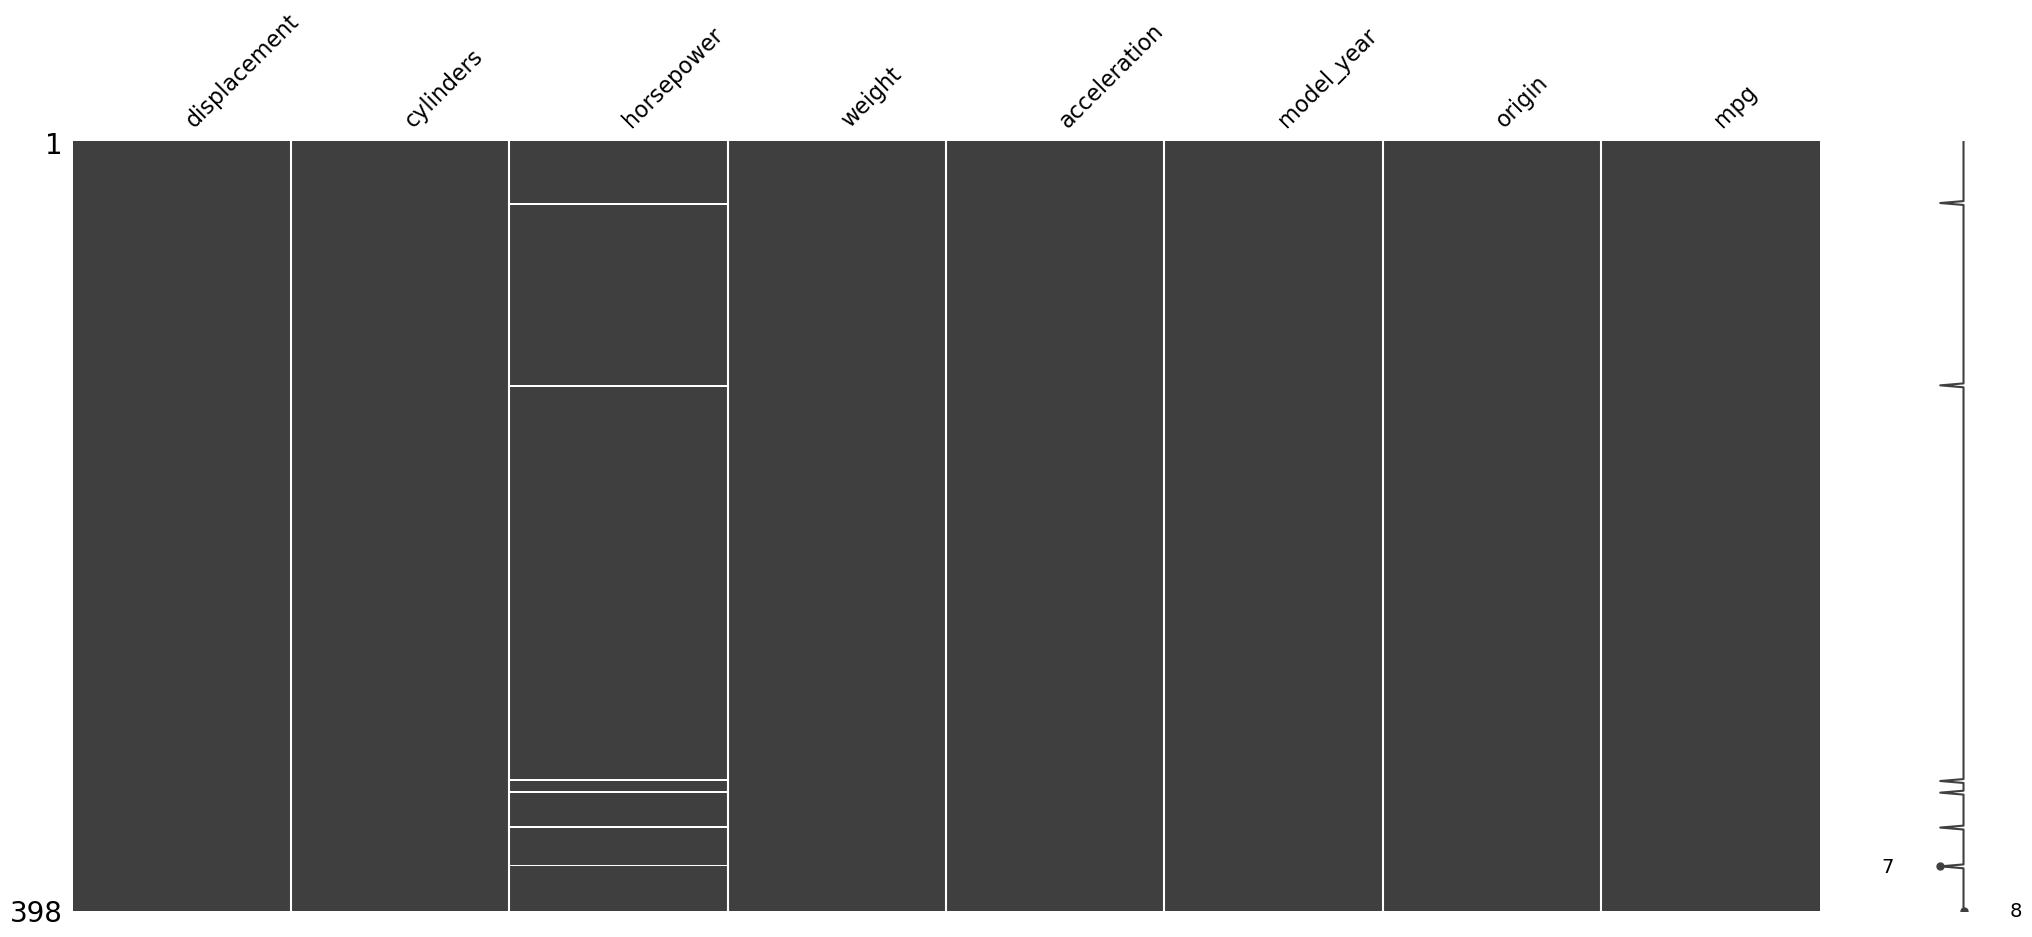

In [1694]:
msno.matrix(df_raw)

In [1695]:
# Calculando parâmetros estatísticos com skewness, kurtosis e coeficiente de variação
estatisticas = calcular_estatisticas_descritivas(df_raw)
estatisticas

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis,cv
displacement,398.0,193.43,104.27,68.0,104.25,148.5,262.00,455.0,387.0,0.72,-0.75,0.54
cylinders,398.0,5.45,1.70,3.0,4.00,4.0,8.00,8.0,5.0,0.53,-1.38,0.31
horsepower,392.0,104.47,38.49,46.0,75.00,93.5,126.00,230.0,184.0,1.09,0.70,0.37
weight,398.0,2970.42,846.84,1613.0,2223.75,2803.5,3608.00,5140.0,3527.0,0.53,-0.79,0.29
acceleration,398.0,15.57,2.76,8.0,13.82,15.5,17.18,24.8,16.8,0.28,0.42,0.18
model_year,398.0,76.01,3.70,70.0,73.00,76.0,79.00,82.0,12.0,0.01,-1.18,0.05
origin,398.0,1.57,0.80,1.0,1.00,1.0,2.00,3.0,2.0,0.92,-0.82,0.51
mpg,398.0,23.51,7.82,9.0,17.50,23.0,29.00,46.6,37.6,0.46,-0.51,0.33


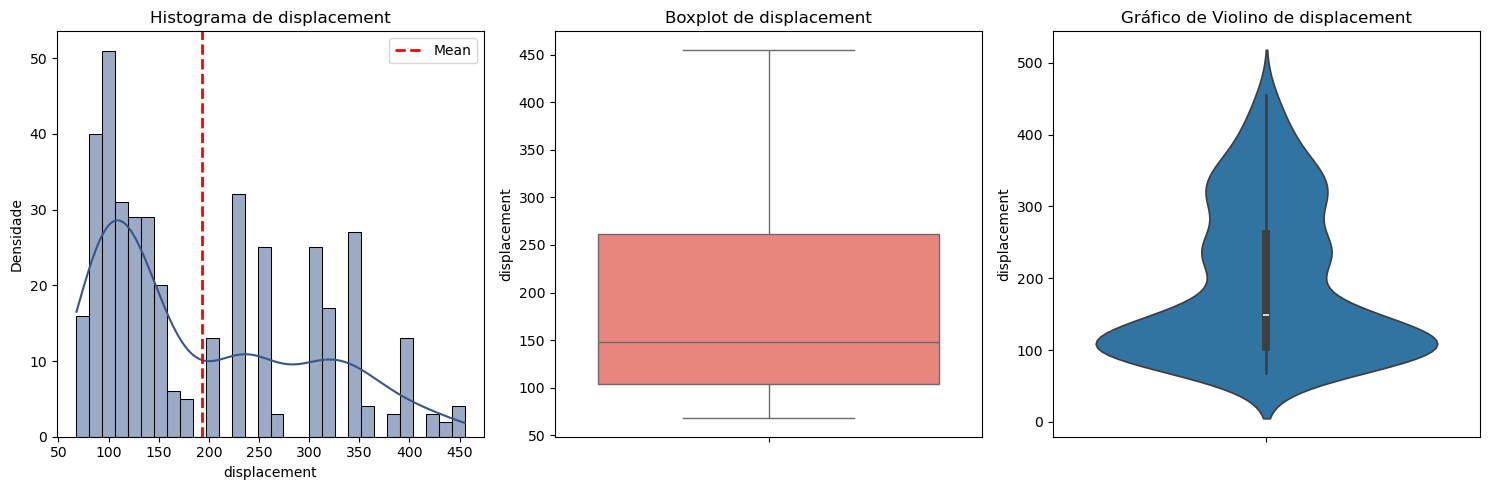

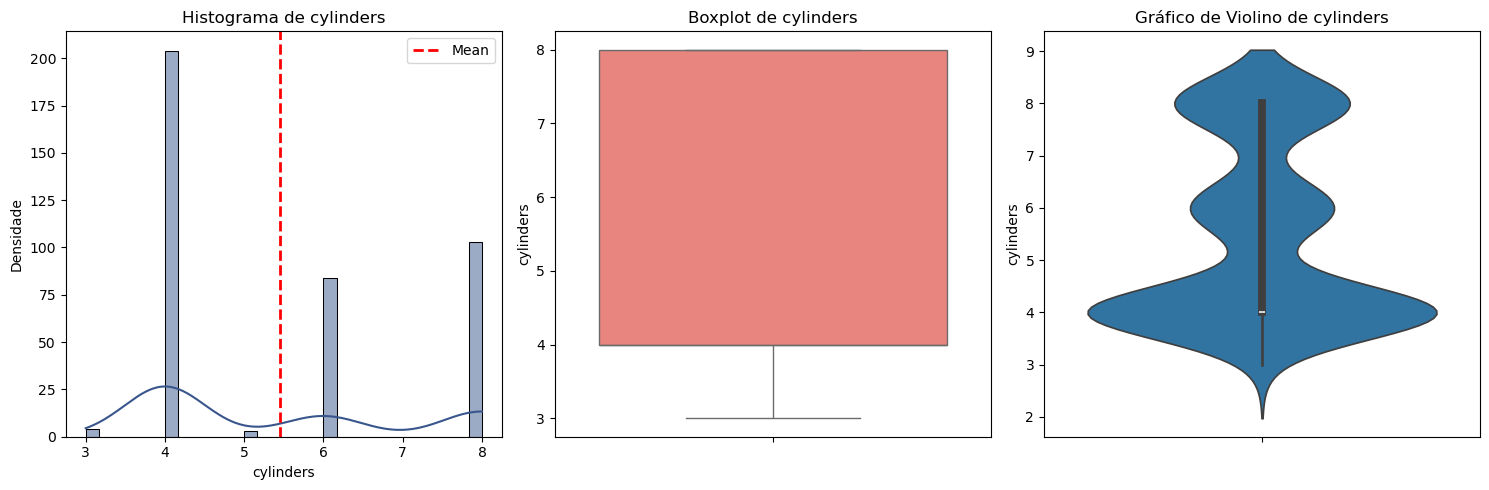

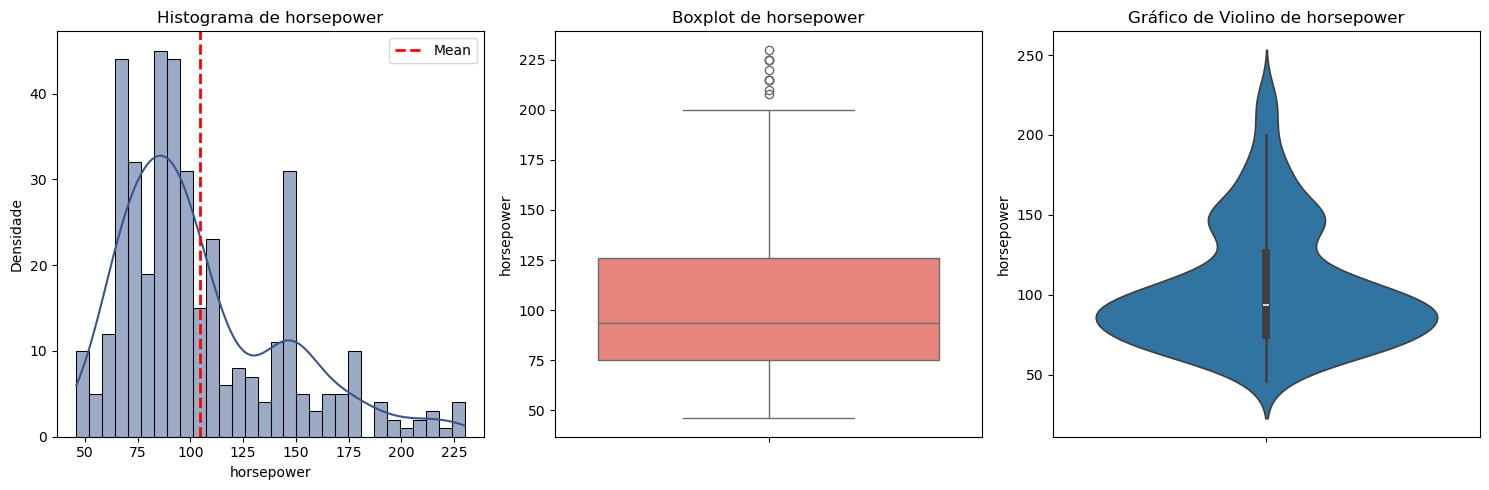

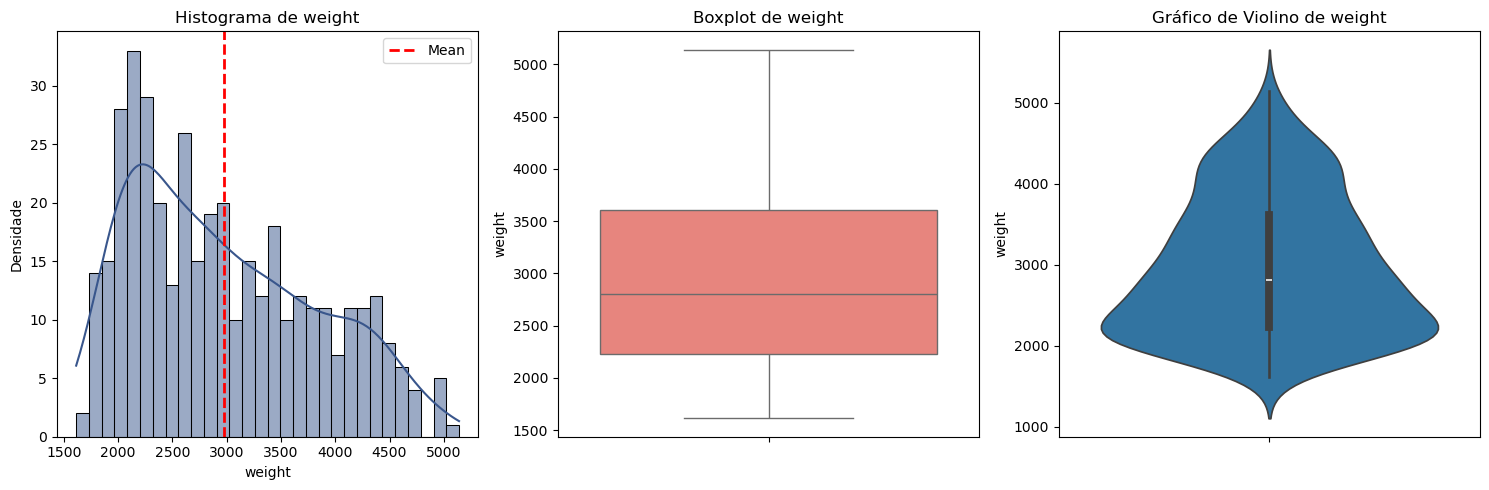

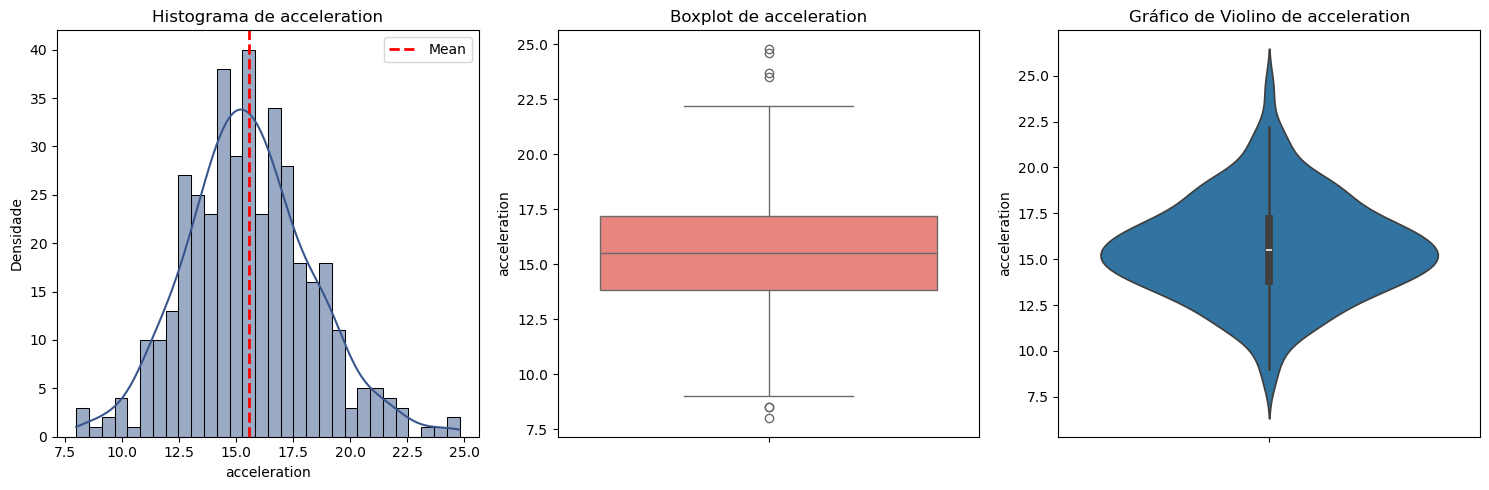

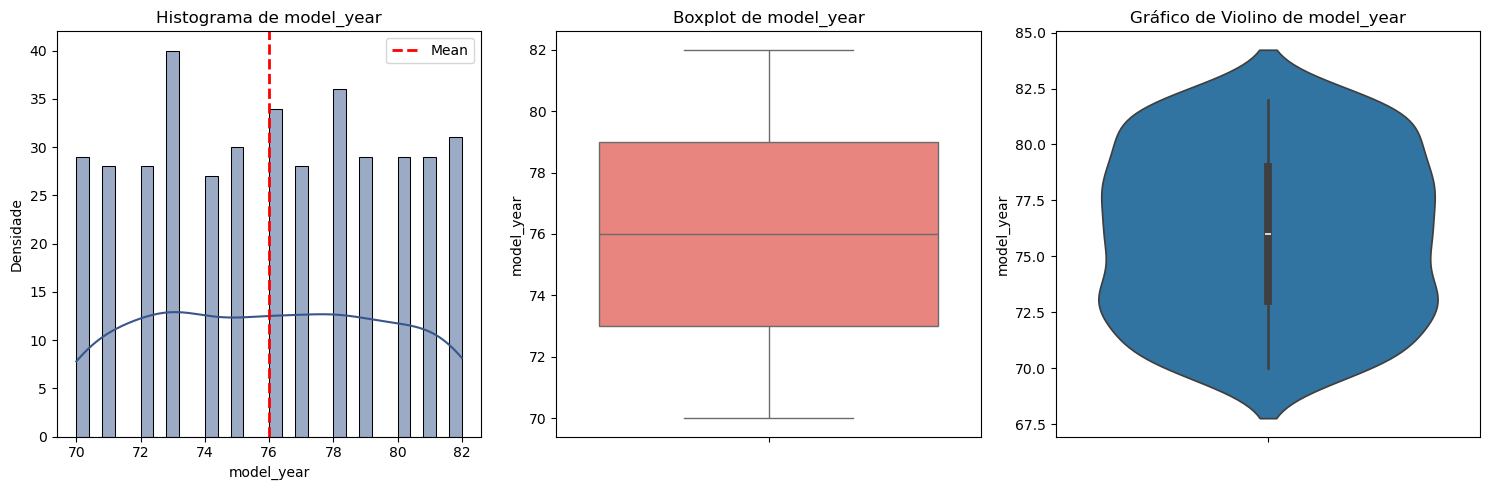

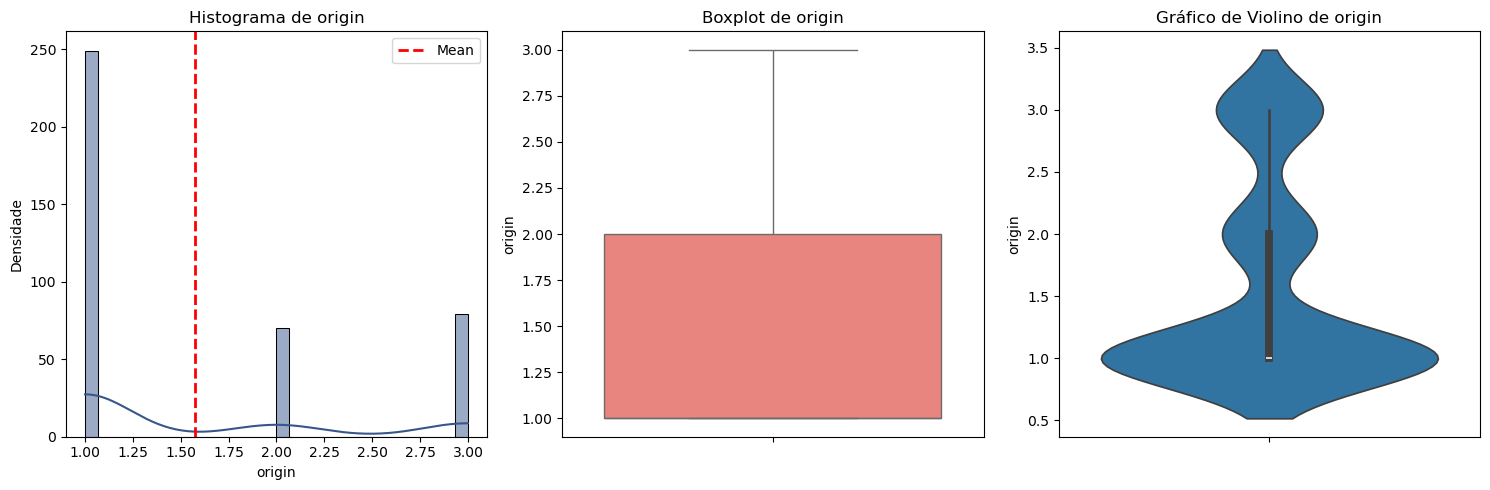

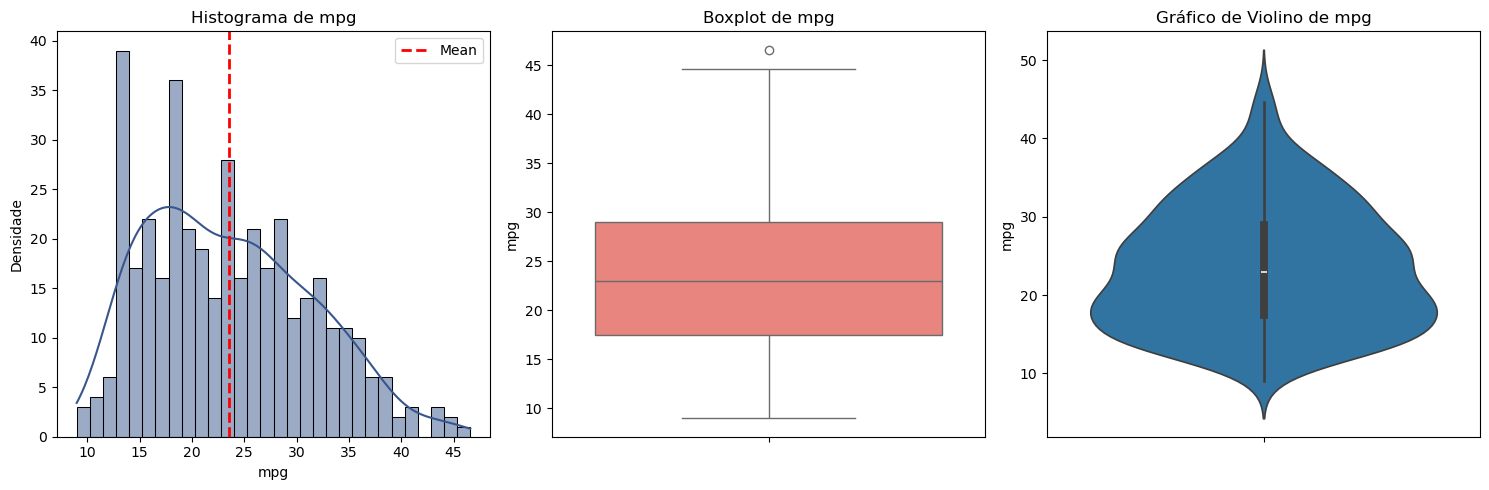

In [1696]:
# Gerando boxplot, histograma e violino de cada variável
def plot_histogram_boxplot(df_raw):
    
    # Gera histogramas e boxplots para todas as colunas numéricas de um DataFrame.

    num_cols = df_raw.select_dtypes(include=['number']).columns  # Filtra apenas colunas numéricas
    
    for coluna in num_cols:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Criar subplots lado a lado

        # Histograma com densidade
        sns.histplot(df_raw[coluna], kde=True, bins=30, color="#39568C", ax=axes[0]) # kde=True adiciona a curva de densidade
        axes[0].set_title(f"Histograma de {coluna}")
        axes[0].set_ylabel("Densidade")
        axes[0].axvline(df_raw[coluna].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")  # Linha da média
        axes[0].legend() 

        # Boxplot
        sns.boxplot(y=df_raw[coluna], color="#F8766D", ax=axes[1])
        axes[1].set_title(f"Boxplot de {coluna}")

        # Gráfico de violino
        sns.violinplot(y=df_raw[coluna], ax=axes[2])
        axes[2].set_title(f"Gráfico de Violino de {coluna}")

        plt.tight_layout()
        plt.show()

# Exemplo de uso:
plot_histogram_boxplot(df_raw)

<code style="color:purple">Comentários - Análise Univariada</code>

| **Análise**                          | **Observações**                                                                 |
|--------------------------------------|----------------------------------------------------------------------------|
| **Tipos de variáveis**               | Muitas variáveis categóricas ou que não seguem distribuição normal |
| **Valores ausentes**                 | Variável Horsepower possui dados nulos. Substituir por média de mesmo cylinders |
| **Unidades de medidas**              | Variáveis estão em unidades de medidas que não facilitam a interpretação para brasileiros |
| **Média e Mediana**                  | Alguns valores de média e mediana apresentam diferença considerável |
| **Desvio padrão**                    | Valores de desvio padrão muito variados |
| **Mínimo e Máximo**                  |  |
| **Distribuição de variáveis**        | Maioria das variáveis não seguem distribuição normal |
| **Outliers**                         | horsepower, acceleration e mpg possuem outliers |
| **Escalas**                          | Escalas de valores muito diferentes. Pode requerer normalização. |
| **Skewness**                         | Valores longe de zero, indica distribuição não normal |
| **Kurtosis**                         | Valores longe de 3, indica excesso ou falta de valores extremos |

# <center>PREPARAÇÃO DOS DADOS

<code style="color:green">Pré-processamento e Limpeza dos dados</code>

- Verificar observações sobre a análise univariada com a área de negócio e realizar tratamento dos dados (dados faltantes, unidades de medidas, data types)
- Realizar transformação de dados se necessário (normalização, dummização).
- Criar ABT

## <center>Tratamento de dados

- Ajustes de dados faltantes
- Ajustes de unidades de medidas
- Ajustes de data types

In [1697]:
# Fazendo uma cópia do dataframe para evitar alterações no original
df = df_raw.copy()

# Renomeando colunas para evitar espaços e caracteres especiais
df.columns = rename_columns(df.columns)

In [1698]:
df.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


In [1699]:
# Tratando dados faltantes de horsepower

# Calculando média de horsepower por cylinders
media_hp_por_cilindros = df.groupby('cylinders')['horsepower'].mean()
# Preenchendo valores ausentes de horsepower com a média por cilindros
df['horsepower'] = df.apply(
    lambda row: media_hp_por_cilindros[row['cylinders']] if pd.isna(row['horsepower']) else row['horsepower'], 
    axis=1
)

In [1700]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    398 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [1701]:
# Verificar se existem valores inconsistentes no y

idx_drop = df_raw[df['mpg'] < 0].index
df.iloc[idx_drop]

# Remover os dados da amostra
df = df.drop(idx_drop, axis=0).reset_index(drop=True)

# Validar quantidade de linhas e sequência do índice
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   horsepower    398 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    int64  
 6   origin        398 non-null    int64  
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 25.0 KB


In [1702]:
# Transformando variáveis categóricas em string
df['origin'] = df['origin'].astype(str)
df['cylinders'] = df['cylinders'].astype(str)
df['model_year'] = df['model_year'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   displacement  398 non-null    float64
 1   cylinders     398 non-null    object 
 2   horsepower    398 non-null    float64
 3   weight        398 non-null    int64  
 4   acceleration  398 non-null    float64
 5   model_year    398 non-null    object 
 6   origin        398 non-null    object 
 7   mpg           398 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 25.0+ KB


<code style="color:green">Testar normalidade de variáveis após limpeza</code>

In [1703]:
# Avaliando a normalidade das variáveis numéricas através de teste de Shapiro-Wilk

for coluna in df_raw.select_dtypes(include=[np.number]).columns:
    stat, p = shapiro(df_raw[coluna])
    print(f"Teste de Shapiro-Wilk para {coluna}: Estatística={stat:.3f}, p-valor={p:.3f}")
    if p > 0.05:
        print(f"A variável {coluna} parece seguir uma distribuição normal (falha em rejeitar H0)\n")
    else:
        print(f"A variável {coluna} não parece seguir uma distribuição normal (rejeita H0)\n")


Teste de Shapiro-Wilk para displacement: Estatística=0.880, p-valor=0.000
A variável displacement não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para cylinders: Estatística=0.749, p-valor=0.000
A variável cylinders não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para horsepower: Estatística=nan, p-valor=nan
A variável horsepower não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para weight: Estatística=0.941, p-valor=0.000
A variável weight não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para acceleration: Estatística=0.992, p-valor=0.040
A variável acceleration não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para model_year: Estatística=0.946, p-valor=0.000
A variável model_year não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para origin: Estatística=0.674, p-valor=0.000
A variável origin não parece seguir um

## <center>Transformação de Variáveis Independentes

<code style="color:green">Normalização</code>

Lidando com variáveis que não seguem distribuição normal

In [1704]:
# Definindo variável dependente
y = df['mpg']

# Definindo variáveis independentes
X = df.drop(columns=['mpg'])

# Definindo variáveis numéricas e categóricas
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Transformando todas as variáveis numéricas em log na base 10
for col in df[num_cols]:
    col_log = f'{col}_log'
    df[col_log] = np.log10(df[col] + 2)  #Adiciona 2 para evitar log(0)

df.head(2)

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg,displacement_log,horsepower_log,weight_log,acceleration_log
0,307.0,8,130.0,3504,12.0,70,1,18.0,2.489958,2.120574,3.544812,1.146128
1,350.0,8,165.0,3693,11.5,70,1,15.0,2.546543,2.222716,3.567614,1.130334


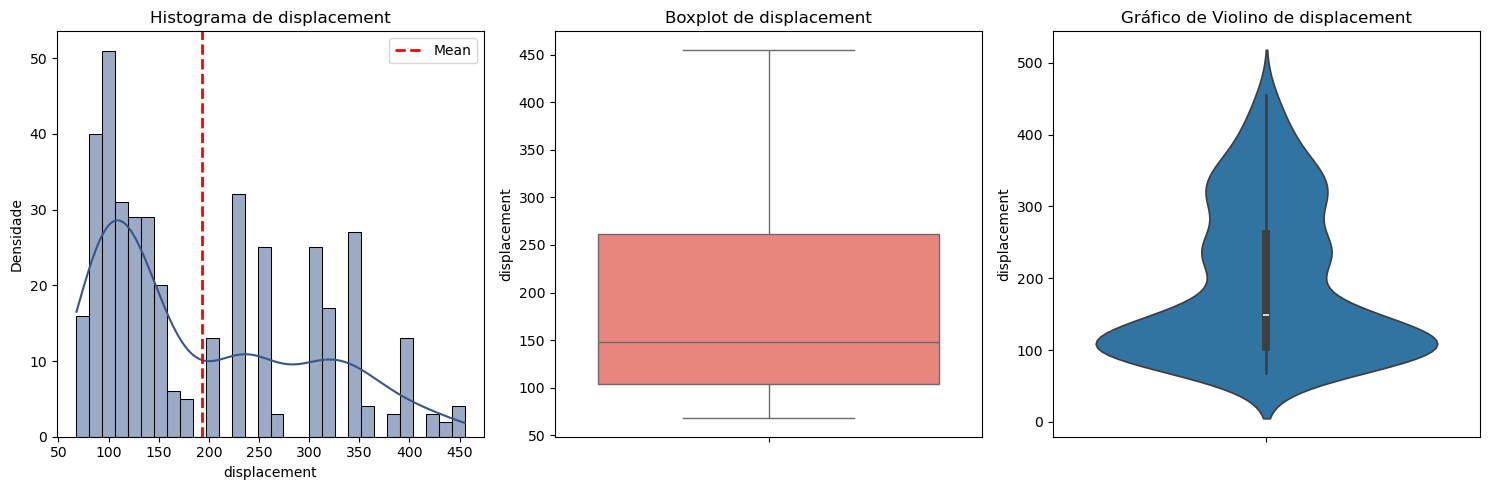

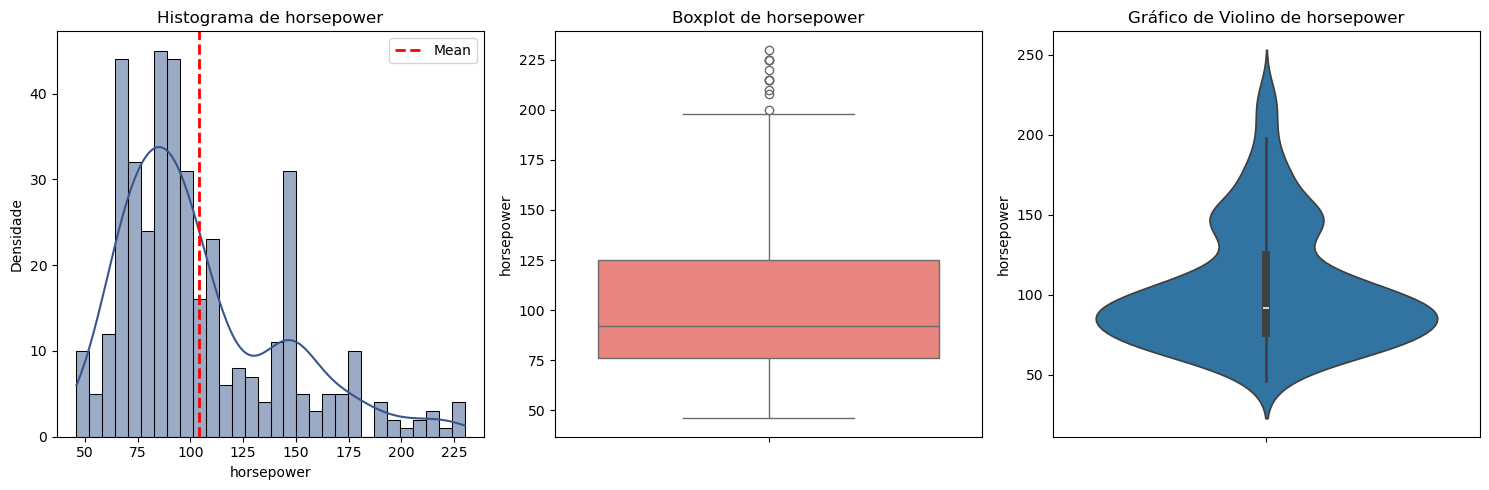

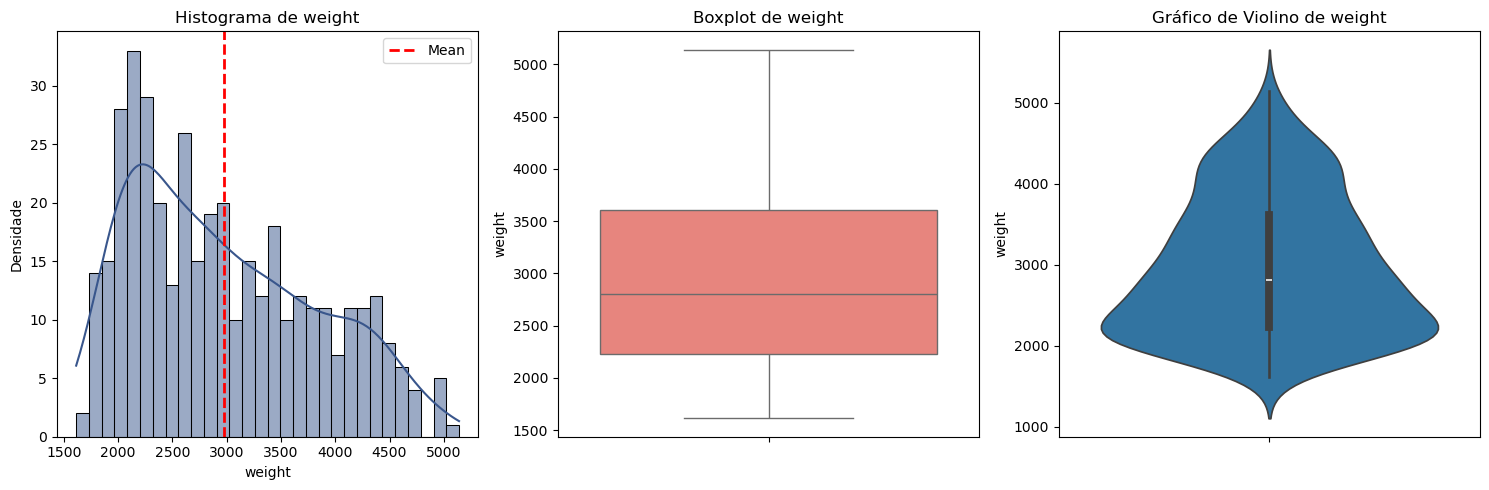

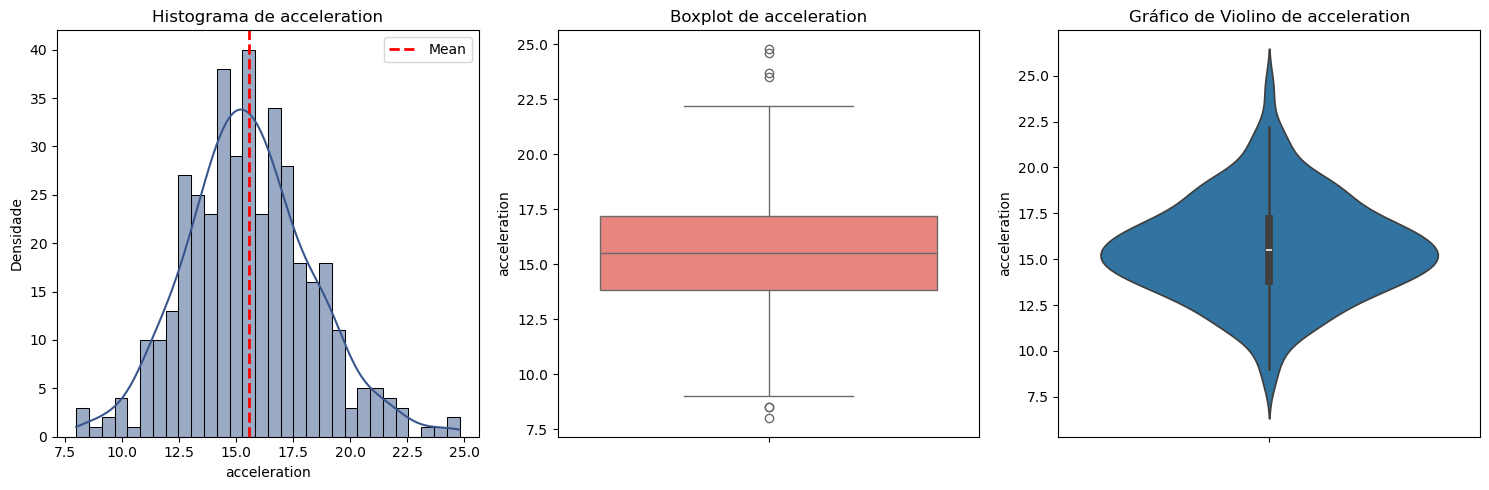

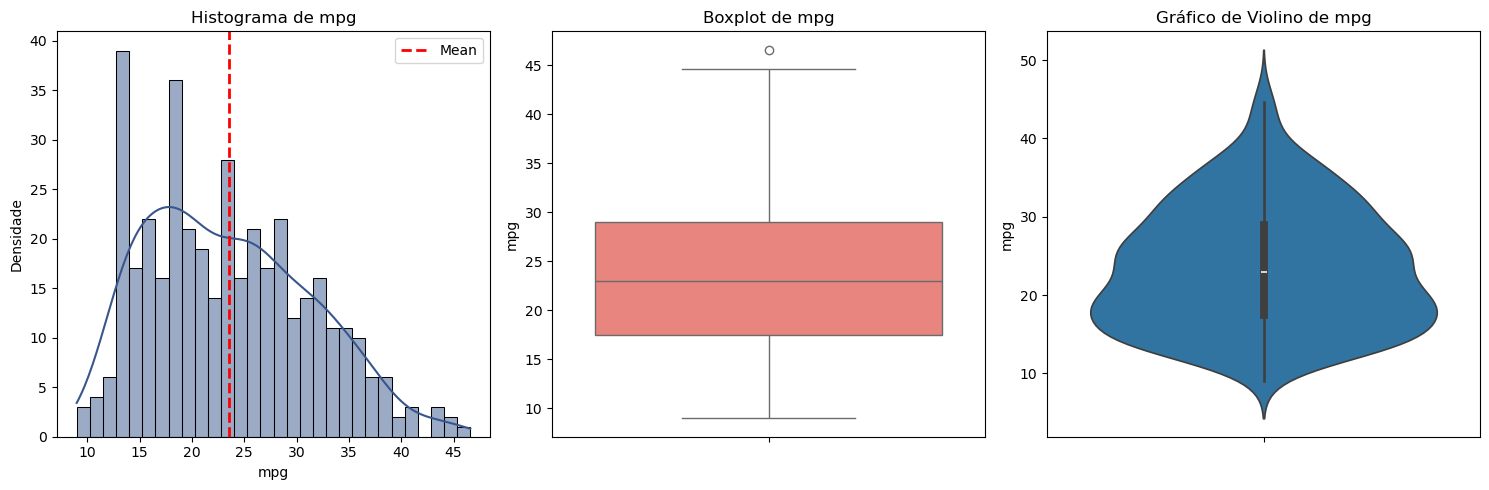

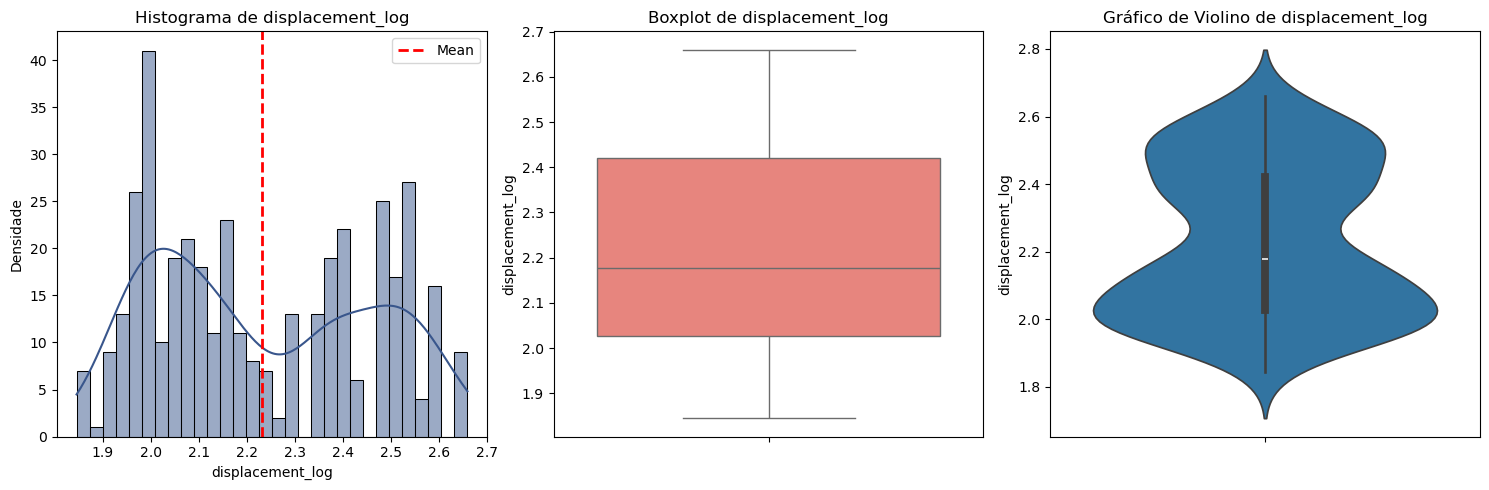

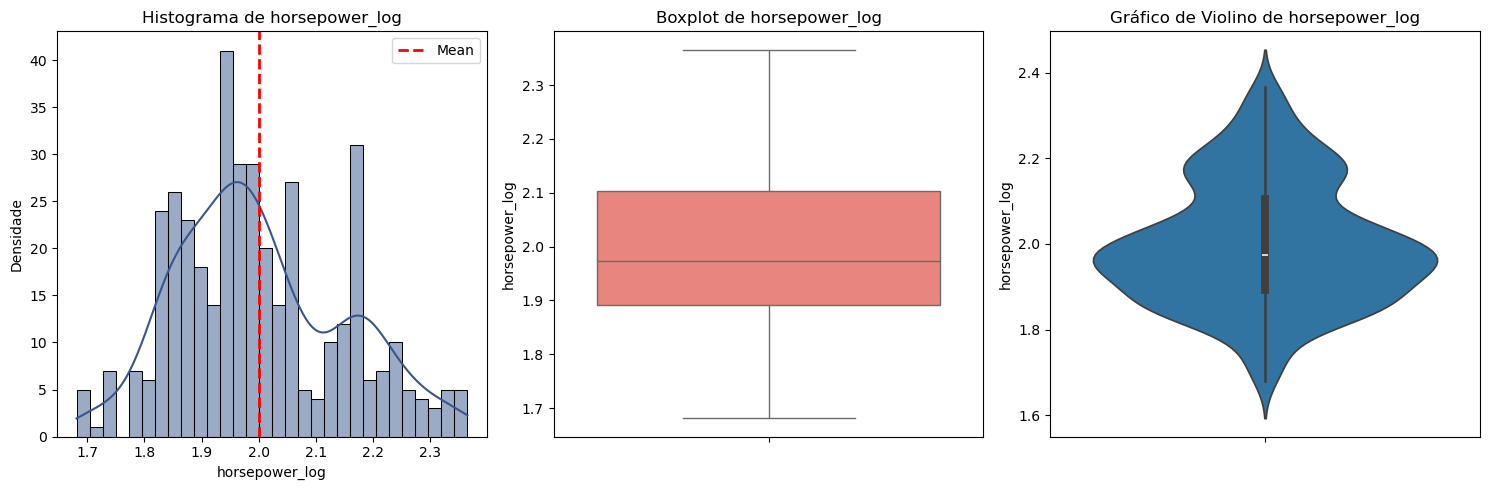

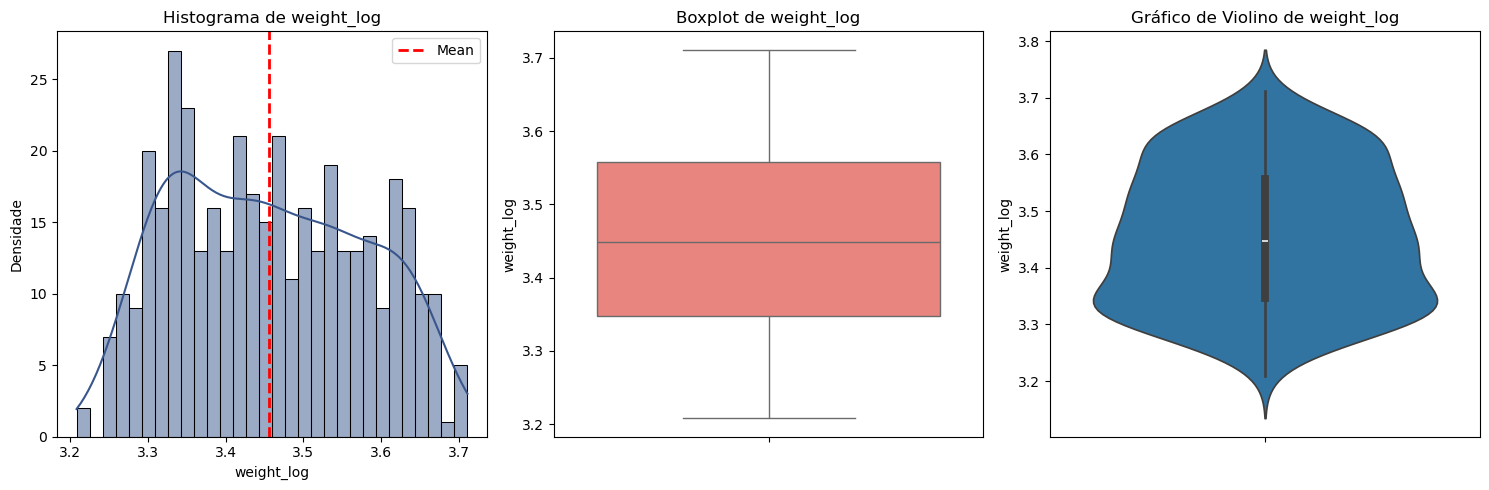

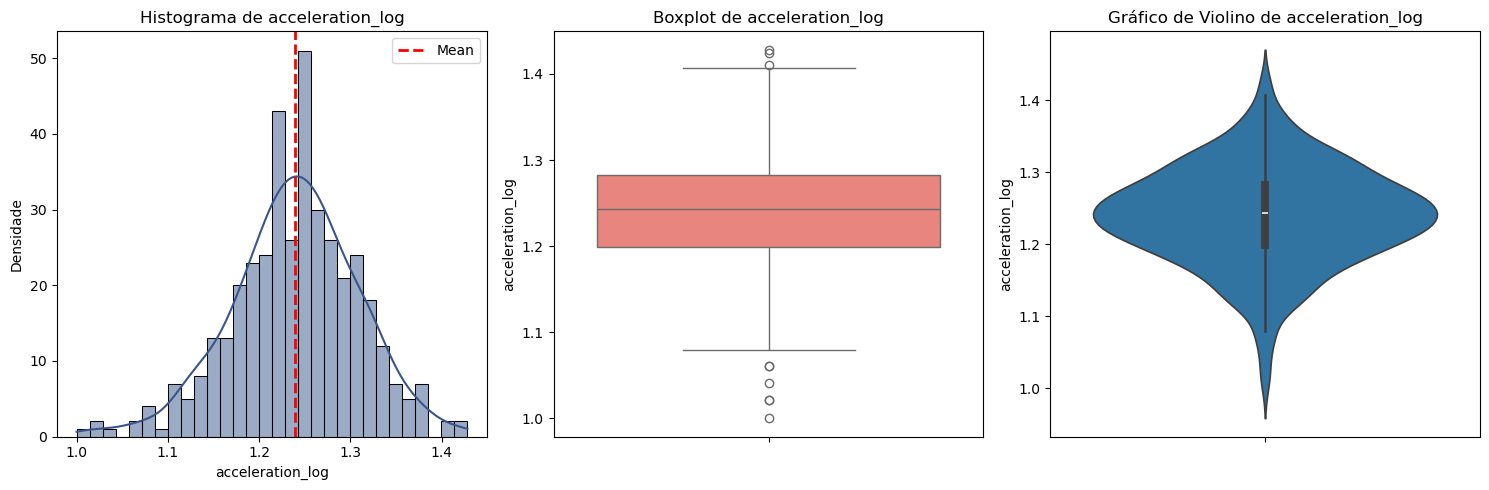

In [1705]:
# Gerando boxplot, histograma e violino de cada variável para verificar efeito da transformação logarítmica

def plot_histogram_boxplot(df):
    
    # Gera histogramas e boxplots para todas as colunas numéricas de um DataFrame.

    num_cols = df.select_dtypes(include=['number']).columns  # Filtra apenas colunas numéricas
    
    for coluna in num_cols:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Criar subplots lado a lado

        # Histograma com densidade
        sns.histplot(df[coluna], kde=True, bins=30, color="#39568C", ax=axes[0]) # kde=True adiciona a curva de densidade
        axes[0].set_title(f"Histograma de {coluna}")
        axes[0].set_ylabel("Densidade")
        axes[0].axvline(df[coluna].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")  # Linha da média
        axes[0].legend() 

        # Boxplot
        sns.boxplot(y=df[coluna], color="#F8766D", ax=axes[1])
        axes[1].set_title(f"Boxplot de {coluna}")

        # Gráfico de violino
        sns.violinplot(y=df[coluna], ax=axes[2])
        axes[2].set_title(f"Gráfico de Violino de {coluna}")

        plt.tight_layout()
        plt.show()

# Exemplo de uso:
plot_histogram_boxplot(df)

In [1706]:
# Filtrando colunas numéricas que terminam com "_log"
colunas_log = [col for col in df if col.endswith('_log')]

# Avaliando a normalidade com o teste de Shapiro-Wilk apenas para essas colunas
for coluna in colunas_log:
    stat, p = shapiro(df[coluna].dropna())  # dropna para evitar erros se houver NaNs
    print(f"Teste de Shapiro-Wilk para {coluna}: Estatística={stat:.3f}, p-valor={p:.3f}")
    if p > 0.05:
        print(f"A variável {coluna} parece seguir uma distribuição normal (falha em rejeitar H0)\n")
    else:
        print(f"A variável {coluna} não parece seguir uma distribuição normal (rejeita H0)\n")

Teste de Shapiro-Wilk para displacement_log: Estatística=0.925, p-valor=0.000
A variável displacement_log não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para horsepower_log: Estatística=0.973, p-valor=0.000
A variável horsepower_log não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para weight_log: Estatística=0.964, p-valor=0.000
A variável weight_log não parece seguir uma distribuição normal (rejeita H0)

Teste de Shapiro-Wilk para acceleration_log: Estatística=0.992, p-valor=0.031
A variável acceleration_log não parece seguir uma distribuição normal (rejeita H0)



<code style="color:purple">Resultados da transformação de variáveis independentes</code>

Mesmo após a transformação logarítmica, as variáveis continuam apresentando distribuição não normal

<code style="color:green">Agrupamento de Categorias</code>

Lidando com variáveis categóricas

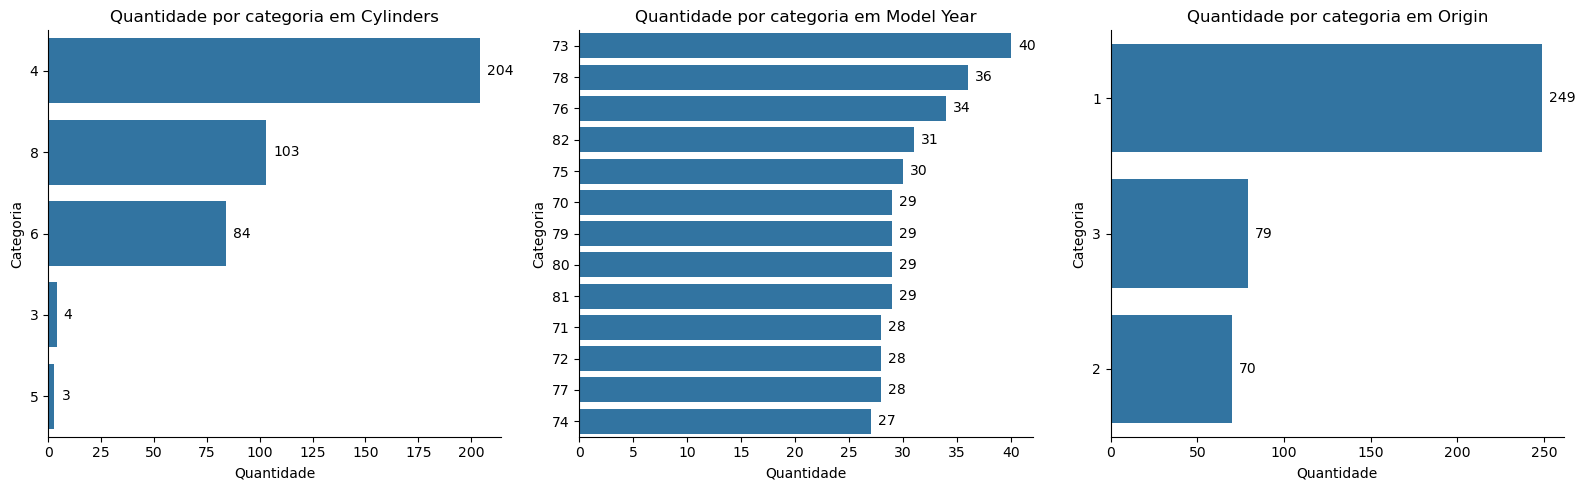

In [1707]:
# Checando categorias e quantidades de valores em cada categoria dos campos cylinders, model_year, origin
# Plotando os gráficos de contagem
plot_countplots(df, ['cylinders', 'model_year', 'origin'], fig_width=16, subplot_width=5)

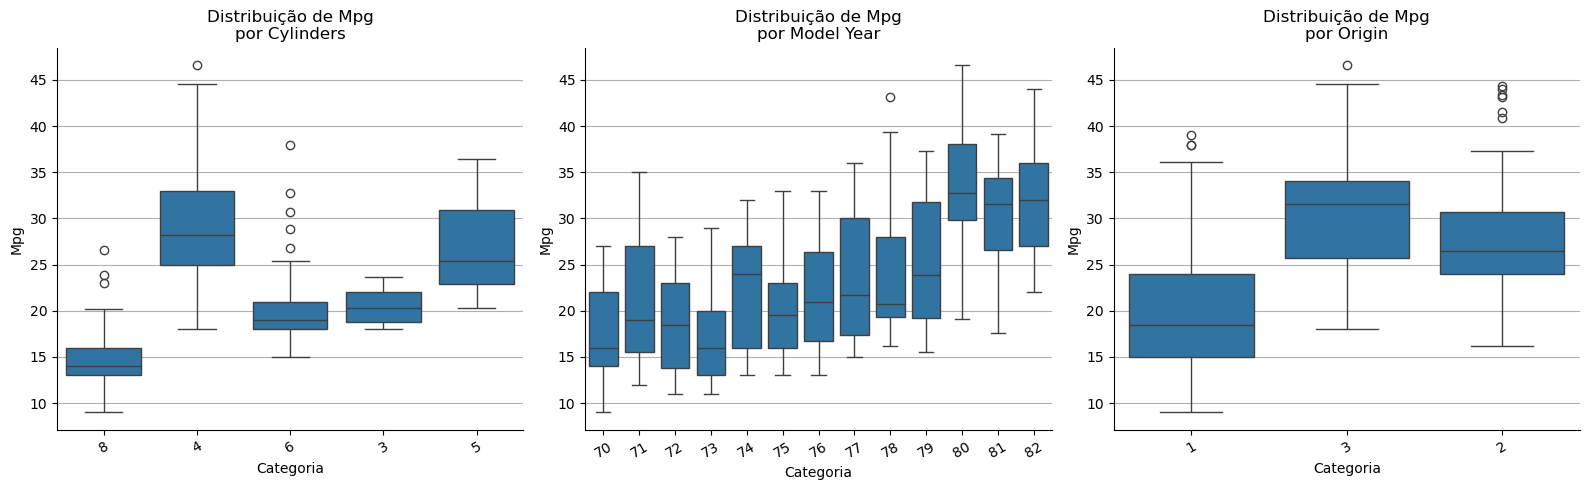

In [1708]:
# Criar o boxplot
plot_boxplots(df, ['cylinders', 'model_year', 'origin'], 'mpg', fig_width=16, subplot_height=5, rotation=30)

In [1709]:
df.groupby('model_year').agg(
    n = ('model_year','size'),
    mediampg = ('mpg','mean')
)

,n,mediampg
model_year,,
70,29,17.689655
71,28,21.250000
72,28,18.714286
73,40,17.100000
74,27,22.703704
75,30,20.266667
76,34,21.573529
77,28,23.375000
78,36,24.061111


In [1710]:
df.groupby('cylinders').agg(
    n = ('cylinders','size'),
    mediampg = ('mpg','mean')
)

,n,mediampg
cylinders,,
3,4,20.550000
4,204,29.286765
5,3,27.366667
6,84,19.985714
8,103,14.963107


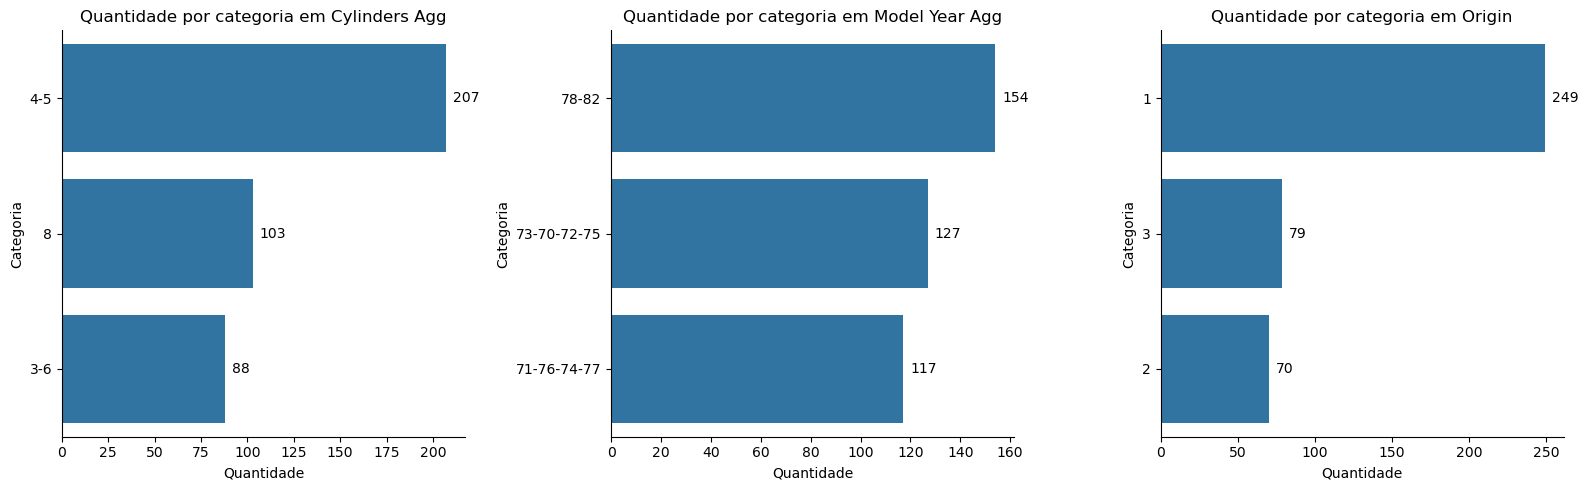

In [1711]:
# Categorizando os dados dos campos cylinders, model_year, origin para que nenhuma categoria seja pouco representativa

# Criando uma variável que agrupa os dados de cylinders em 3 categorias

df['cylinders_agg'] = np.where(df['cylinders'].isin(['4','5']), '4-5', np.where(df['cylinders'].isin(['3','6']), '3-6', '8'))
# Criando uma variável que agrupa os dados de model_year em 4 categorias
df['model_year_agg'] = np.where(df['model_year'].isin(['73','70','72','75']), '73-70-72-75', np.where(df['model_year'].isin(['71','76','74','77']), '71-76-74-77', np.where(df['model_year'].isin(['78','79','80','81','82']), '78-82', '83+')))

# Plotando novas categorias
plot_countplots(df, ['cylinders_agg', 'model_year_agg', 'origin'], fig_width=16, subplot_width=5)

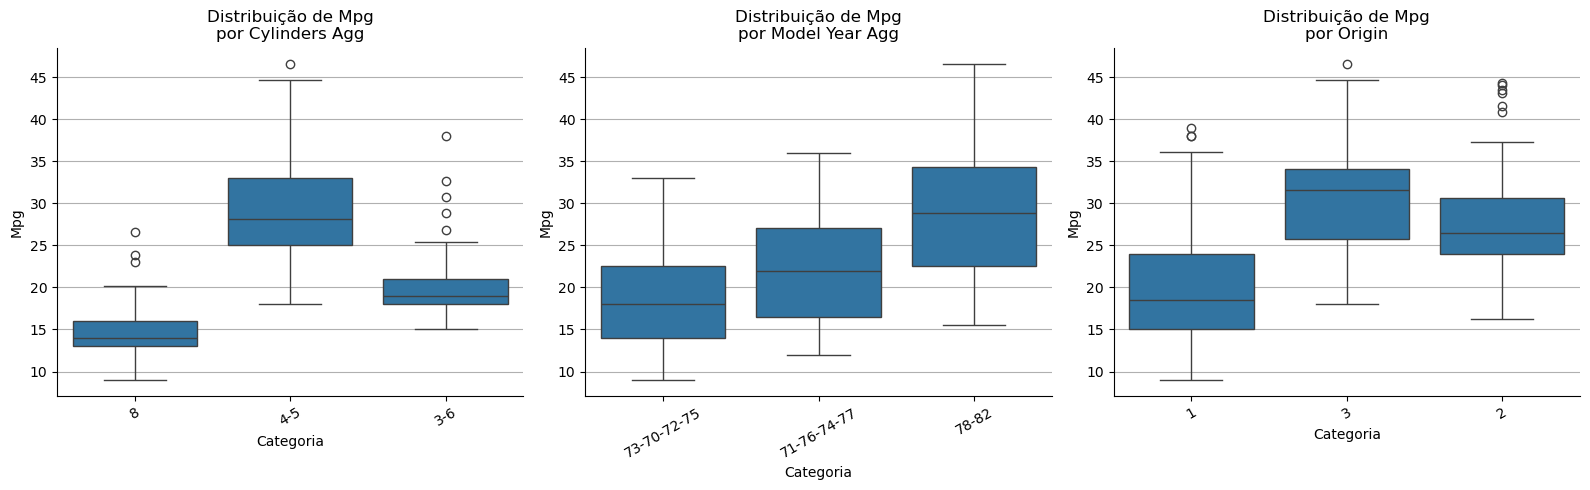

In [1712]:
plot_boxplots(df, ['cylinders_agg', 'model_year_agg', 'origin'], 'mpg', fig_width=16, subplot_height=5, rotation=30)

<code style="color:green">Dummização</code>

Criando variáveis dummies para utilizar categorias na regressão

In [1713]:
df.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg,displacement_log,horsepower_log,weight_log,acceleration_log,cylinders_agg,model_year_agg
0,307.0,8,130.0,3504,12.0,70,1,18.0,2.489958,2.120574,3.544812,1.146128,8,73-70-72-75
1,350.0,8,165.0,3693,11.5,70,1,15.0,2.546543,2.222716,3.567614,1.130334,8,73-70-72-75
2,318.0,8,150.0,3436,11.0,70,1,18.0,2.505150,2.181844,3.536306,1.113943,8,73-70-72-75
3,304.0,8,150.0,3433,12.0,70,1,16.0,2.485721,2.181844,3.535927,1.146128,8,73-70-72-75
4,302.0,8,140.0,3449,10.5,70,1,17.0,2.482874,2.152288,3.537945,1.096910,8,73-70-72-75


In [1714]:
# Definindo colunas que serão transformadas em dummies
dummy_cols = ['cylinders_agg', 'model_year_agg', 'origin']

# Criando as variáveis dummies para as variáveis categóricas
dummies = pd.get_dummies(df[dummy_cols], drop_first=True)

# Adicionando "dummy" ao final de cada nome de coluna
dummies.columns = [f"{col}_dummy" for col in dummies.columns]

# Concatenando as variáveis dummy com o DataFrame original
df = pd.concat([df, dummies], axis=1)

# Transformando variáveis dummies em int
df.loc[:, df.columns.str.endswith('_dummy')] = df.loc[:, df.columns.str.endswith('_dummy')].astype(int)

df.head()

C:\Users\laris\AppData\Local\Temp\ipykernel_44960\3816829412.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1
 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1]' has d

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg,displacement_log,horsepower_log,weight_log,acceleration_log,cylinders_agg,model_year_agg,cylinders_agg_4-5_dummy,cylinders_agg_8_dummy,model_year_agg_73-70-72-75_dummy,model_year_agg_78-82_dummy,origin_2_dummy,origin_3_dummy
0,307.0,8,130.0,3504,12.0,70,1,18.0,2.489958,2.120574,3.544812,1.146128,8,73-70-72-75,0,1,1,0,0,0
1,350.0,8,165.0,3693,11.5,70,1,15.0,2.546543,2.222716,3.567614,1.130334,8,73-70-72-75,0,1,1,0,0,0
2,318.0,8,150.0,3436,11.0,70,1,18.0,2.505150,2.181844,3.536306,1.113943,8,73-70-72-75,0,1,1,0,0,0
3,304.0,8,150.0,3433,12.0,70,1,16.0,2.485721,2.181844,3.535927,1.146128,8,73-70-72-75,0,1,1,0,0,0
4,302.0,8,140.0,3449,10.5,70,1,17.0,2.482874,2.152288,3.537945,1.096910,8,73-70-72-75,0,1,1,0,0,0


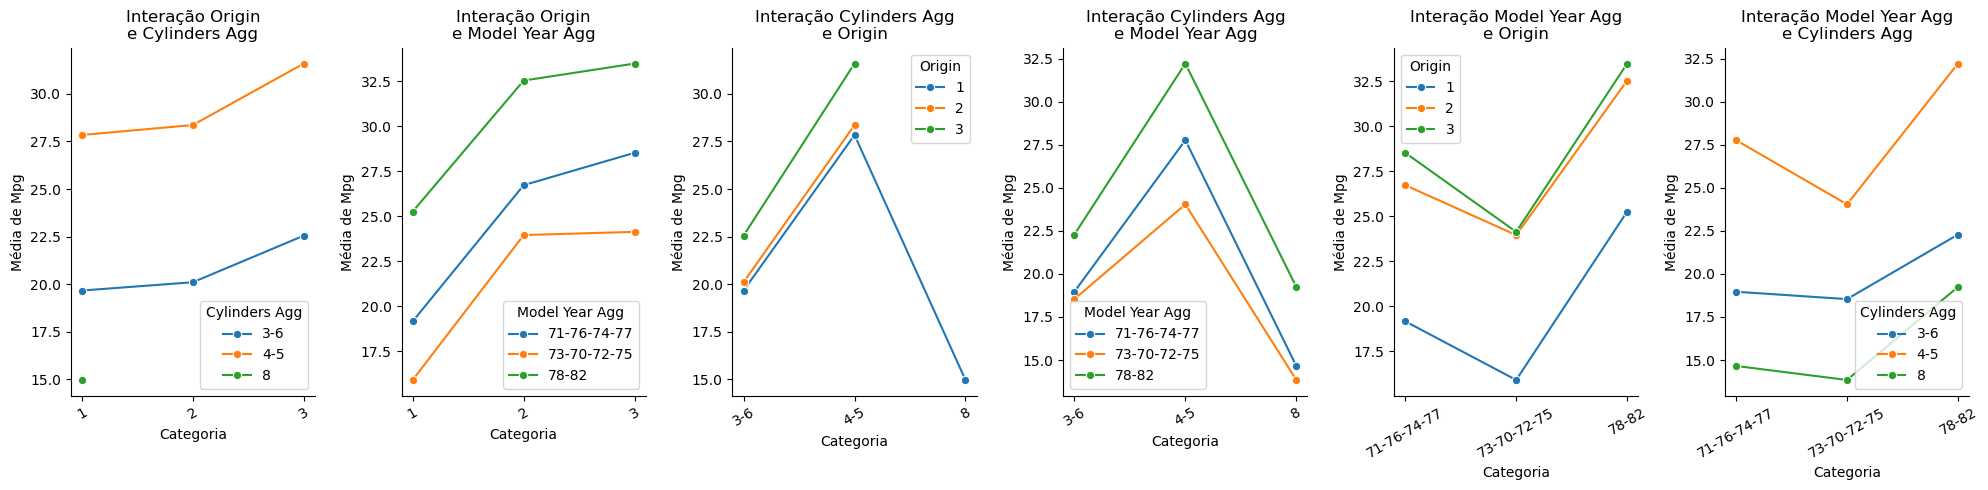

In [1715]:
# Colunas a serem plotadas
col1 = 'origin'       
col2 = 'cylinders_agg'
col3 = 'model_year_agg'  
col_hue1 = 'origin'
col_hue2 = 'cylinders_agg'
col_hue3 = 'model_year_agg'
# Plotando interações entre variáveis categóricas e a variável target   

plot_line_interactions(df, 
                       x_columns=[col1, col1, col2, col2, col3, col3],
                       hue_columns=[col_hue2, col_hue3, col_hue1, col_hue3, col_hue1, col_hue2],
                       target_col='mpg')

In [1716]:
df_dinamic = df.copy()

# Removendo colunas que foram transformadas em dummies
df_dinamic = df_dinamic.drop(columns=['cylinders', 'model_year', 'cylinders_agg', 'model_year_agg', 'origin'])
# Removendo colunas que foram transformadas em log
df_dinamic = df_dinamic.drop(columns=['displacement', 'horsepower', 'weight', 'acceleration'])

df_dinamic.head()

,mpg,displacement_log,horsepower_log,weight_log,acceleration_log,cylinders_agg_4-5_dummy,cylinders_agg_8_dummy,model_year_agg_73-70-72-75_dummy,model_year_agg_78-82_dummy,origin_2_dummy,origin_3_dummy
0,18.0,2.489958,2.120574,3.544812,1.146128,0,1,1,0,0,0
1,15.0,2.546543,2.222716,3.567614,1.130334,0,1,1,0,0,0
2,18.0,2.505150,2.181844,3.536306,1.113943,0,1,1,0,0,0
3,16.0,2.485721,2.181844,3.535927,1.146128,0,1,1,0,0,0
4,17.0,2.482874,2.152288,3.537945,1.096910,0,1,1,0,0,0


# <center>ANÁLISE EXPLORATÓRIA DOS DADOS

<code style="color:green">Etapas da EDA</code>

- Análise bivariada
- Avaliar e tratar multicolinearidade
- Fazer descritiva com foco no modelo
- Validar pressupostos

<code style="color:green">Análise Bivariada</code>

- Cruzar variáveis e identificar correlação de pearson
- Observar relação entre cada variável independente e a variável dependente para identificar correlação visualmente (vontade de traçar uma reta angular?)
- Analisar matriz de correlação (acima de 0,7 indica alta correlação)
- Escolhar quais variáveis manter no modelo

| **Análise**       | **Função/Ferramenta**                       | **Instrução**                                  | **Exemplos** |
|-------------------|---------------------------------------------|------------------------------------------------|--------------|
| **Colinearidade** | Gráficos de dispersão, matriz de correlação | Identificar relações lineares entre variáveis. | - |


Essa análise ajuda a evitar problemas como multicolinearidade no modelo.

In [1717]:
TARGET_COL = ['mpg']
SELECTED_COLS = df_dinamic.drop(columns=TARGET_COL).columns.tolist()

X = df_dinamic[SELECTED_COLS]
y = df_dinamic[TARGET_COL]

<Figure size 1200x1000 with 0 Axes>

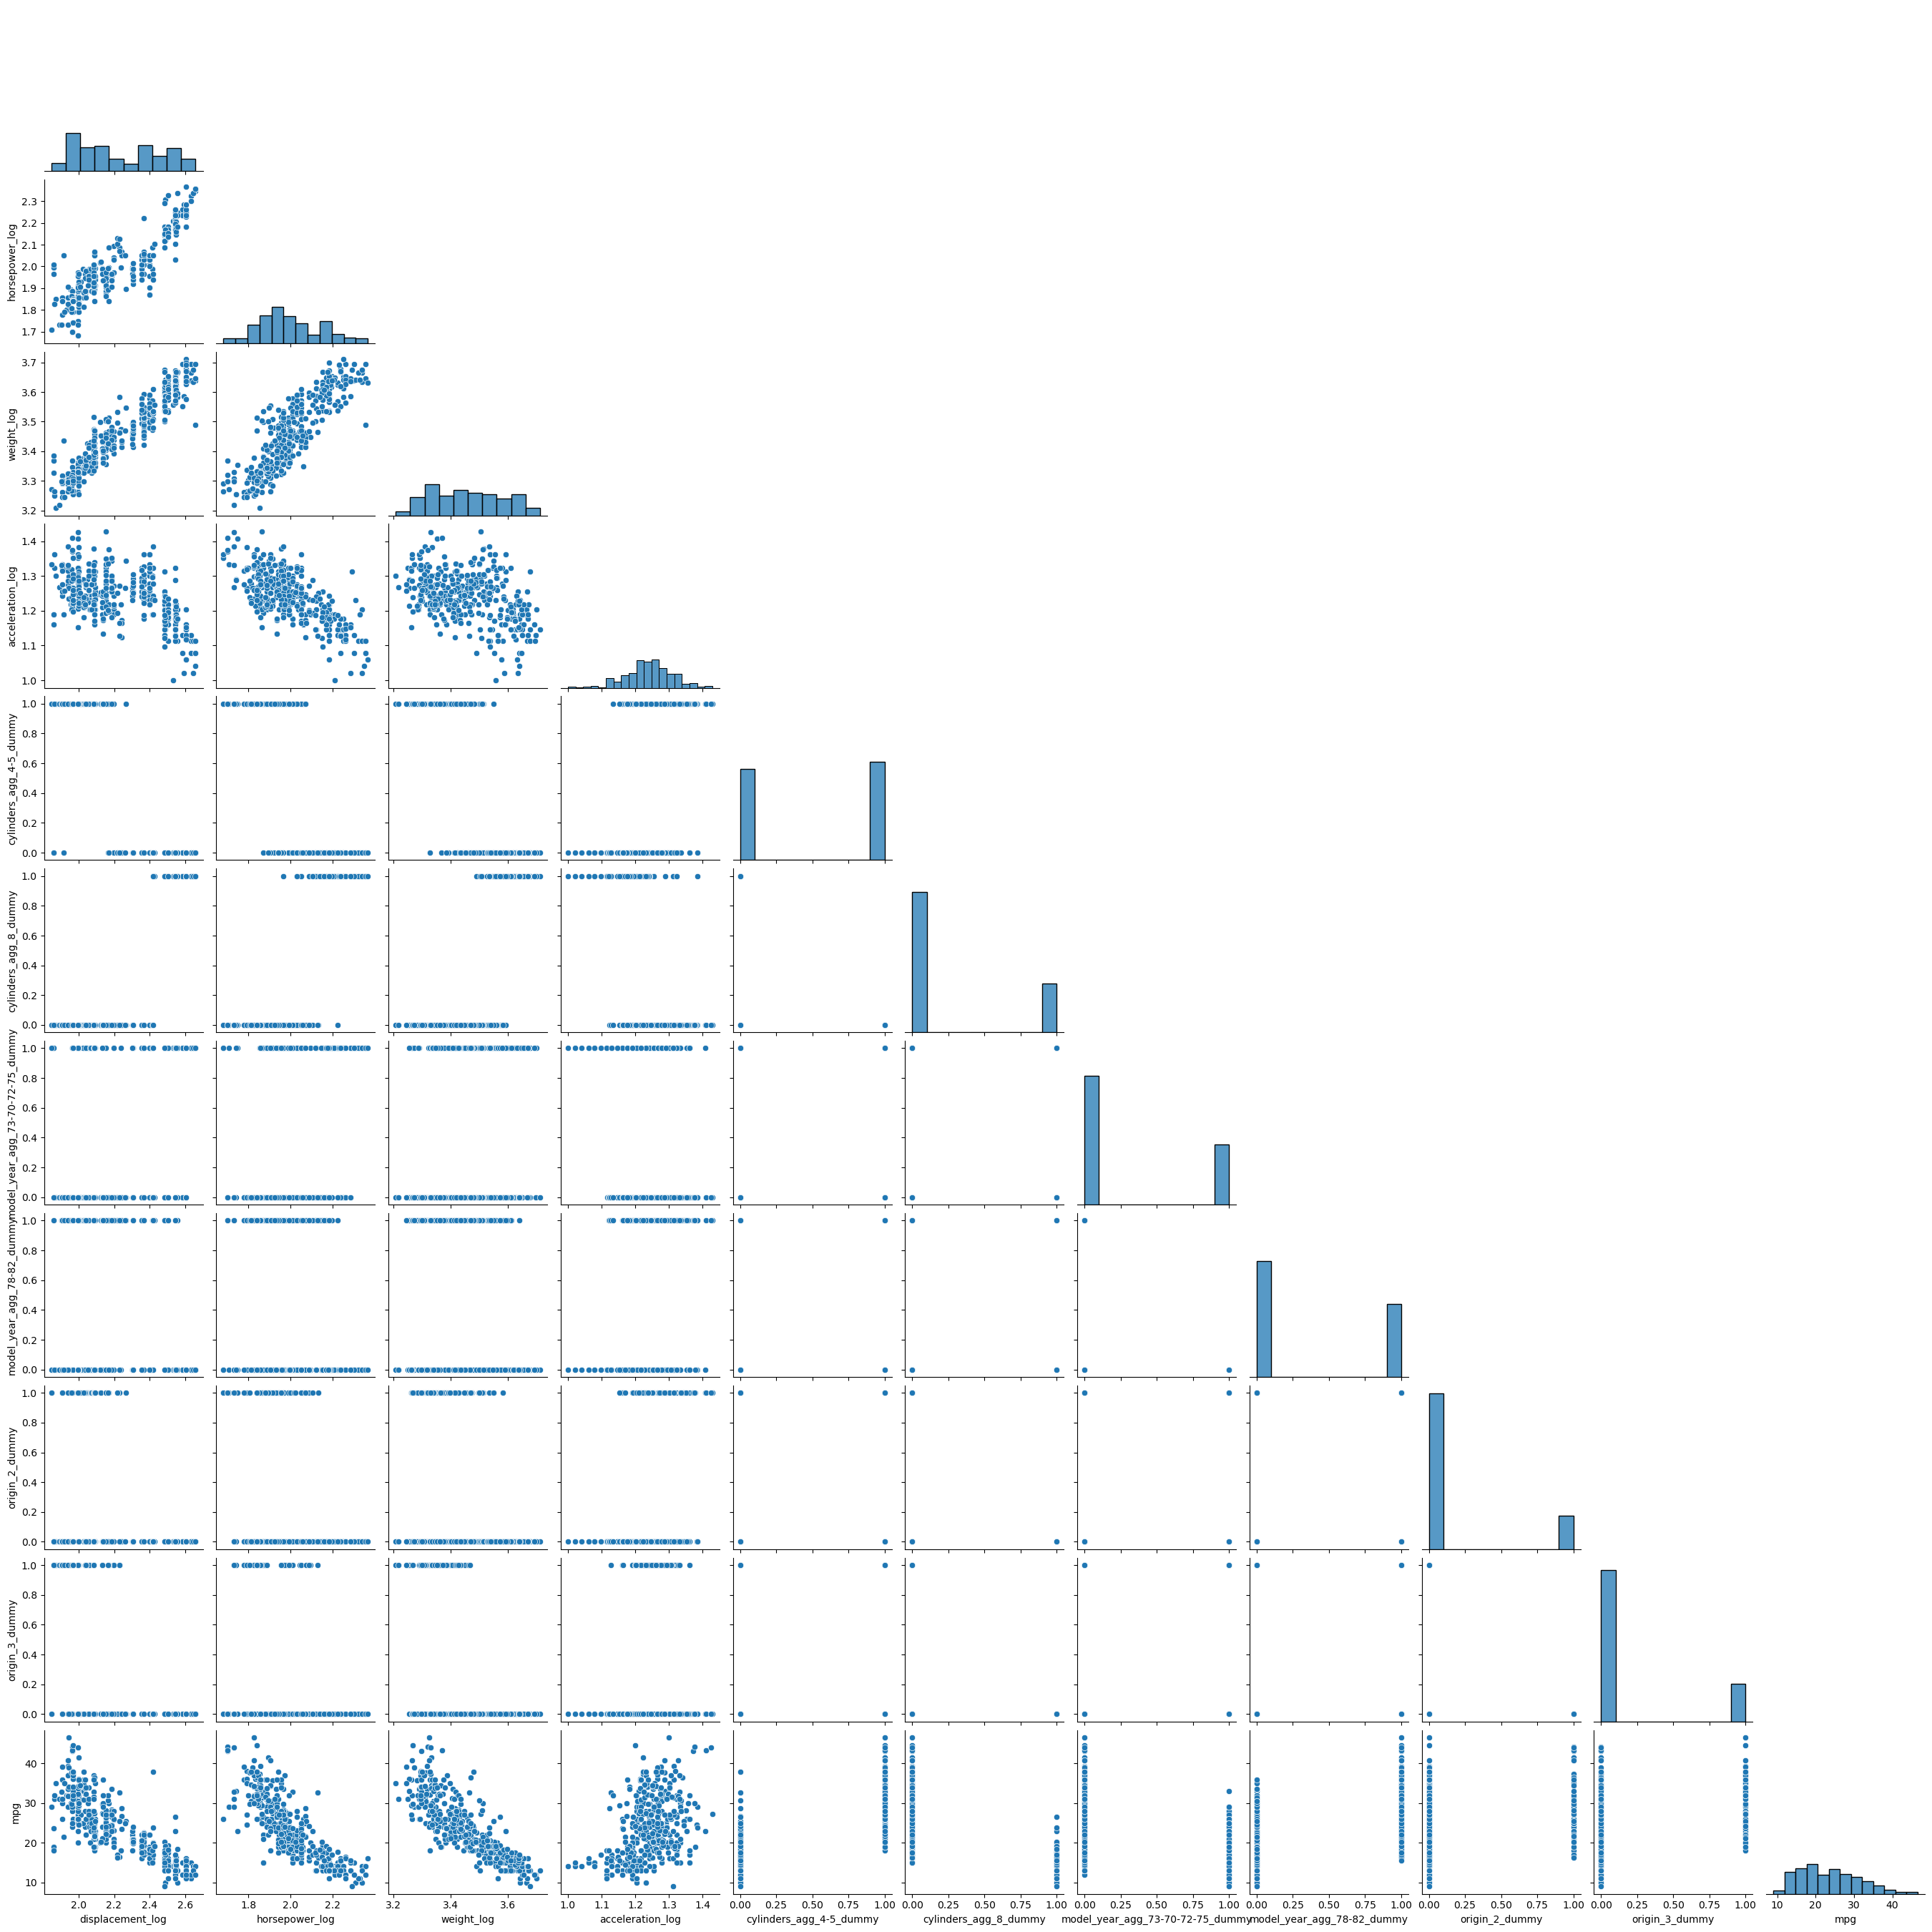

In [1718]:
# Gerando gráficos de dispersão entre todas as variáveis

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))  # Ajuste o tamanho conforme necessário

# Verificar linearidade (gráficos de dispersão)
sns.pairplot(df_dinamic[SELECTED_COLS + TARGET_COL], corner=True)

# Mostrar o gráfico
plt.show()

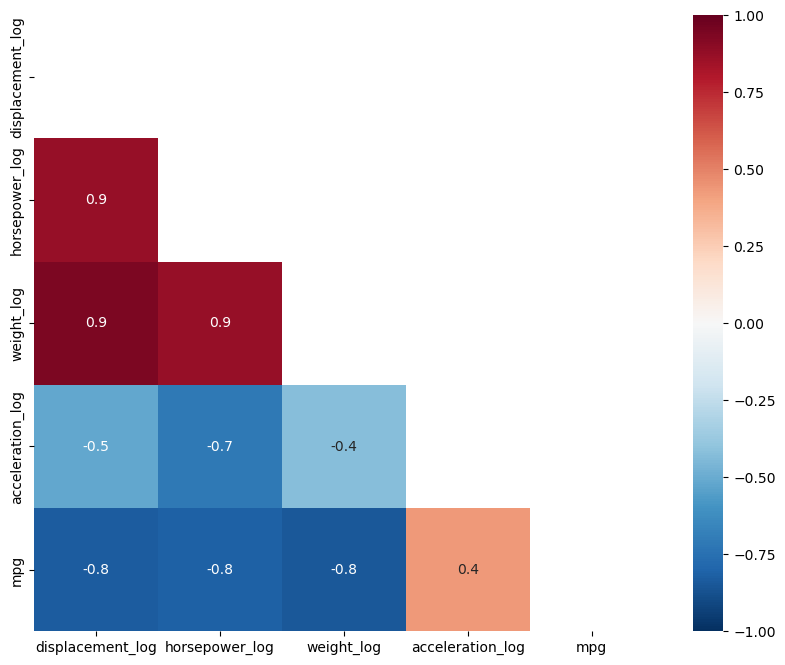

In [1719]:
# Heatmap para cálculo de correlação com valores de correlação entre variáveis numéricas com final _log

# Selecionando colunas com final _log
colunas_log = [col for col in df_dinamic.columns if col.endswith('_log')]
colunas_log.append('mpg')

corr_matrix = df_dinamic[colunas_log].corr()

# Criar a máscara para a parte superior da matriz, evitando redundância já que a matriz é simétrica
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Ajustar o tamanho da figura
plt.figure(figsize=(10, 8))

# Criar o heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.1f', center=0, vmax=1, vmin=-1, cmap="RdBu_r", annot_kws={"size": 10}, mask=mask)
plt.show()

<code style="color:purple">Retirando variáveis com alta correlação</code>

In [1720]:
# Retirando variáveis com alta correlação entre si (acima de 0.7)

df_dinamic = df_dinamic.drop(columns=['displacement_log', 'weight_log', 'acceleration_log'])

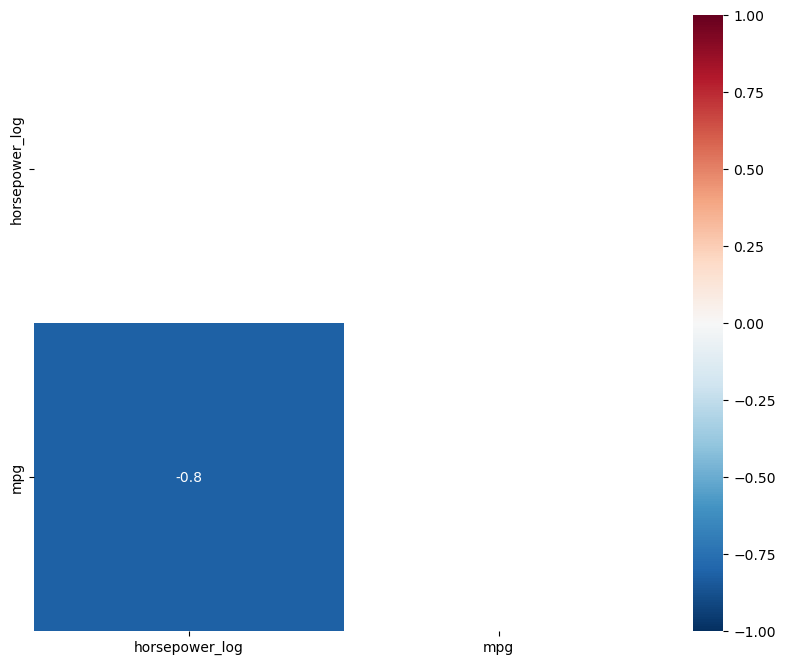

In [1721]:
# Heatmap para cálculo de correlação com valores de correlação entre variáveis numéricas com final _log após seleção de variáveis

# Selecionando colunas com final _log
colunas_log = [col for col in df_dinamic.columns if col.endswith('_log')]
colunas_log.append('mpg')

corr_matrix = df_dinamic[colunas_log].corr()

# Criar a máscara para a parte superior da matriz, evitando redundância já que a matriz é simétrica
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Ajustar o tamanho da figura
plt.figure(figsize=(10, 8))

# Criar o heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.1f', center=0, vmax=1, vmin=-1, cmap="RdBu_r", annot_kws={"size": 10}, mask=mask)
plt.show()

# <center>MODELAGEM

<code style="color:green">Cheat Sheet para interpretação de Resultados - Métricas de Qualidade de Ajuste</code>

| **Métrica**                      | **Descrição**                                                                                                                                                         | **Interpretação**                                                                 |
|----------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Dep. Variable**                | Variável dependente do modelo.                                                                                                                                    | Define a variável que estamos tentando prever.                                  |
| **Model**                        | Modelo de regressão utilizado.                                                                                                                                   | Indica se foi uma regressão OLS ou outro tipo de modelo.                        |
| **Method**                       | Método utilizado para estimar os parâmetros.                                                                                                                      | Normalmente, OLS (Ordinary Least Squares).                                      |
| **Date e Time**                  | Data e horário da análise.                                                                                                                                        | Apenas informativo, não influencia a interpretação.                             |
| **No. Observations**             | Número de observações usadas na regressão.                                                                                                                        | Indica o tamanho da amostra.                                                    |
| **Df Residuals**                 | Graus de liberdade dos resíduos (número de observações - número de variáveis).                                                                                   | Usado para interpretar a significância estatística.                             |
| **Df Model**                     | Número de variáveis independentes no modelo.                                                                                                                      | Indica a complexidade do modelo.                                                |
| **$R^{2}$**                      | Mede a proporção da variação de y explicada pelo modelo em %. Quanto mais próximo de 1 (100%), melhor o ajuste.                                                  | Se baixo, modelo não explica bem a variabilidade de y. Se muito alto, pode indicar overfitting. |
| **$R^{2}$ ajustado**             | Penaliza modelos com muitas variáveis irrelevantes.                                                                                                              | Se muito menor que $R^{2}$, algumas variáveis podem não contribuir significativamente. Útil para comparar modelos com diferentes números de variáveis. |
| **Estatística F**                | Testa a significância global do modelo.                                                                                                                           | Se significativa (F alto comparando com F tabelado), modelo tem pelo menos uma variável relevante (coeficiente diferente de zero). |
| **Prob (F-statistic)**           | Probabilidade associada à estatística F. Se < 0,05, rejeita-se H0, indicando que pelo menos uma variável independente é significativa.                            | Se < 0,05, modelo é estatisticamente significativo. |
| **Log-Likelihood**               | Mede a qualidade do ajuste (log-verossimilhança).                                                                                                                | Comparável entre modelos; quanto maior, melhor. |
| **AIC e BIC**                    | Critérios para comparar modelos. BIC penaliza mais modelos com muitas variáveis.                                                                                 | Valores menores indicam melhor ajuste com menos complexidade. |
| **Omnibus**                      | Teste estatístico para verificar se os resíduos seguem uma distribuição normal.                                                                                   | Se p-valor for alto, não rejeitamos a hipótese de normalidade. |
| **Prob(Omnibus)**                | Probabilidade associada ao teste Omnibus.                                                                                                                         | Se < 0,05, os resíduos não seguem distribuição normal. |
| **Skew**                         | Mede a assimetria da distribuição dos resíduos.                                                                                                                   | Valores próximos de 0 indicam simetria; valores muito negativos ou positivos indicam assimetria. |
| **Kurtosis**                     | Mede a curtose da distribuição dos resíduos.                                                                                                                      | Valores próximos de 3 indicam distribuição normal. |
| **Durbin-Watson**                | Testa a presença de autocorrelação nos resíduos.                                                                                                                 | Valores próximos de 2 indicam ausência de correlação serial. |
| **Jarque-Bera (JB)**             | Teste de normalidade dos resíduos.                                                                                                                                | Se p-valor < 0,05, rejeita-se normalidade. |
| **Prob(JB)**                     | Probabilidade associada ao teste JB.                                                                                                                              | Se < 0,05, os resíduos não seguem distribuição normal. |
| **Condition Number**             | Se muito grande, indica multicolinearidade.                                                                                                                       | Valores acima de 30 podem indicar multicolinearidade séria. |
| **Coeficientes (coef)**          | Impacto de cada variável independente sobre y.                                                                                                                    | Valores positivos indicam relação direta; negativos, inversa. Se coeficiente for pequeno e p-valor alto, a variável pode não ser relevante. |
| **Erro padrão (std err)**         | Mede a incerteza na estimativa do coeficiente. Erros menores indicam maior precisão (em diferentes amostras os resultados seriam os mesmos).                     | Se muito alto, pode indicar problema de multicolinearidade ou baixa qualidade da amostra. |
| **Valor t (t)**                  | Estatística de teste para significância dos coeficientes.                                                                                                         | Quanto maior o valor absoluto, mais significativo o coeficiente. |
| **P>[t]**                        | Resultado do teste t para cada variável. Se > 0,05, não rejeitamos H0 (B=0), indicando que a variável pode não ser significativa.                                | Se < 0,05, variável é significativa para prever y. |
| **Intervalo de confiança**       | Faixa onde o coeficiente pode variar com 95% de confiança. Se incluir 0, a variável pode não ser significativa.                                                  | Se intervalo for muito amplo, há grande incerteza na estimativa do coeficiente. |
| **RMSE (Root Mean Squared Error)** | Mede o erro médio quadrático das previsões. Equipara ao desvio padrão. Penaliza erros grandes.                                                                  | Valores mais próximos de 0 indicam melhor ajuste. |
| **MAE (Mean Absolute Error)**     | Mede o erro médio absoluto das previsões. Menos sensível a outliers que RMSE.                                                                                    | Quanto menor, melhor o ajuste do modelo. |
| **Comparação MAE vs RMSE**       | Se RMSE for muito maior que MAE, indica presença de outliers influentes.                                                                                        | Se valores forem próximos, erros estão distribuídos de maneira uniforme. |


<code style="color:green">Aplicando métodos de seleção de variáveis</code>

In [1722]:
TARGET_COL = ['mpg']
SELECTED_COLS = df_dinamic.drop(columns=TARGET_COL).columns.tolist()

X = df_dinamic[SELECTED_COLS]
y = df_dinamic[TARGET_COL]

In [1723]:
# Criando o seletor
selector = FeatureSelector(metodo='backward', metrica='pvalor')

selector = FeatureSelector(
    metodo='backward',     # Escolha entre 'forward', 'backward' ou 'both'
    metrica='pvalor'       # Escolha entre 'aic', 'bic' ou 'pvalor'
)

# Ajustando o seletor aos dados
selector.fit(X, y)

# Obtendo as variáveis selecionadas
selected_features = selector.selected_features_
print("Variáveis Selecionadas:\n", sorted(selected_features))

# Obtendo os passos de seleção
print("\nPassos de Seleção:")
pd.DataFrame(selector.get_steps()).tail()

Variáveis Selecionadas:
 ['cylinders_agg_4-5_dummy', 'horsepower_log', 'model_year_agg_73-70-72-75_dummy', 'model_year_agg_78-82_dummy', 'origin_2_dummy', 'origin_3_dummy']

Passos de Seleção:


,tipo,var,pvalor
0,backward,"[horsepower_log, cylinders_agg_4-5_dummy, mode...",0.053139


In [1724]:
X = df_dinamic[selected_features]

<code style="color:green">Criando o modelo apenas com as transformações em X</code>

In [1725]:
# Adicionando uma coluna com todos os valores = 1 para que o B0 seja calculado
X = sm.add_constant(X)

# Ajustando o modelo de regressão linear
modelo_transf_x = sm.OLS(y, X).fit()

# Exibindo o resumo do modelo
print(modelo_transf_x.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     303.7
Date:                qua, 30 abr 2025   Prob (F-statistic):          8.59e-144
Time:                        15:11:00   Log-Likelihood:                -1037.6
No. Observations:                 398   AIC:                             2089.
Df Residuals:                     391   BIC:                             2117.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

<code style="color:green">Criando o modelo com transformação em y - Transformação Box-Cox</code>

Para realizar a transformação Box-Cox primeiro precisa-se do valor do $\lambda$:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda} & \text{se } \lambda \neq 0 \\
\log(y) & \text{se } \lambda = 0
\end{cases} 
$$

In [1726]:
# Descobrindo lambda

# criando o objeto para transformar
pt = PowerTransformer('box-cox') 

# ajustando aos dados
power = pt.fit_transform(y) 
# retirando o lambda
lambda_param = pt.lambdas_ 
print(lambda_param)

[0.19735476]


Com o $\lambda$ gerado, pode-se transformar a variável y (note que a variável `power` já é o y transformado)

In [1727]:
df_dinamic['BC_mpg'] = ((y**lambda_param[0]) -1)/ lambda_param[0]
df_dinamic['BC_mpg']

0      3.896664
1      3.579866
2      3.896664
3      3.690706
4      3.796117
         ...   
393    4.643421
394    5.625885
395    4.974536
396    4.713367
397    4.911815
Name: BC_mpg, Length: 398, dtype: float64

In [1728]:
# criando o modelo com todas as X´s sem transformação alguma porem com Y do BoxCox
# Criando o objeto X com a variável independentes. 
# X = df_dinamic[selected_features]
# criando o objeto y com a variável resposta transformada
y_transf = df_dinamic["BC_mpg"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
model_transf_xy = sm.OLS(y_transf, X).fit()
# Resumo do modelo
print(model_transf_xy.summary())

                            OLS Regression Results                            
Dep. Variable:                 BC_mpg   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     392.5
Date:                qua, 30 abr 2025   Prob (F-statistic):          4.62e-162
Time:                        15:11:00   Log-Likelihood:                 10.709
No. Observations:                 398   AIC:                            -7.419
Df Residuals:                     391   BIC:                             20.49
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [1729]:
df_dinamic['ychapeu_transformado'] = model_transf_xy.predict(X)

<code style="color:green">Revertendo a transformação de y</code>

$$\left( \left( BCy \cdot \lambda \right) + 1 \right)^{\left( \frac{1}{\lambda} \right)}$$


In [1730]:
# formula: (((BC_y * lambda) + 1)) ^ (1 / lambda)
# ou seja, vou retransformar o ychapeu_transformado para o ychapeu original

df_dinamic['ychapeu_xy'] = inv_boxcox(df_dinamic['ychapeu_transformado'], lambda_param[0]).round(2)

# mostrando as variáveis que me importam
df_dinamic[['mpg', 'BC_mpg', 'ychapeu_transformado' , 'ychapeu_xy']].head(10)

,mpg,BC_mpg,ychapeu_transformado,ychapeu_xy
0,18.0,3.896664,3.618593,15.34
1,15.0,3.579866,3.416195,13.62
2,18.0,3.896664,3.497186,14.29
3,16.0,3.690706,3.497186,14.29
4,17.0,3.796117,3.555750,14.79
5,15.0,3.579866,3.261015,12.40
6,14.0,3.462927,3.171207,11.74
7,14.0,3.462927,3.190810,11.88
8,14.0,3.462927,3.152040,11.60
9,15.0,3.579866,3.296145,12.67


# <center>VALIDAÇÃO DO MODELO

A Validação do modelo é realizada através da análise visual e de resíduos

<code style="color:green">Análise Visual</code>

In [1731]:
# Calculando a predição de ychapeu_x com o modelo original (sem transformação)
df_dinamic['ychapeu_x'] = modelo_transf_x.predict(X)

# Calcula as métricas de erro
result_xy = ml_error('modelo_xy', y, df_dinamic['ychapeu_xy'])
result_x = ml_error('model_x', y, df_dinamic['ychapeu_x'])

# Mostrando os dados em formato de tabela
result_x = pd.DataFrame(result_x, index=[0])
result_xy = pd.DataFrame(result_xy, index=[1])  # Index diferente para nova linha

resultados_completos = pd.concat([result_x, result_xy], axis=0)

resultados_completos.reset_index(drop=True, inplace=True)

# Mostrar a tabela consolidada
resultados_completos

,model_name,RMSE,MAPE,MSE,MAE
0,model_x,3.280973,0.109140,10.764787,2.506347
1,modelo_xy,3.125952,0.102196,9.771576,2.375804


In [1732]:
# Criando os "chutes"
tentativas = X
tentativas["mpg"]  = y
tentativas["chute_media"]  = tentativas["mpg"].mean()
tentativas["chute_modelo_x"] = df_dinamic['ychapeu_x']
tentativas["chute_modelo_xy"] = df_dinamic['ychapeu_xy'] 
tentativas["erro"] = tentativas["mpg"] - tentativas["chute_modelo_xy"]
tentativas

,const,horsepower_log,cylinders_agg_4-5_dummy,model_year_agg_73-70-72-75_dummy,model_year_agg_78-82_dummy,origin_2_dummy,origin_3_dummy,mpg,chute_media,chute_modelo_x,chute_modelo_xy,erro
0,1.0,2.120574,0,1,0,0,0,18.0,23.514573,15.178350,15.34,2.66
1,1.0,2.222716,0,1,0,0,0,15.0,23.514573,12.867676,13.62,1.38
2,1.0,2.181844,0,1,0,0,0,18.0,23.514573,13.792305,14.29,3.71
3,1.0,2.181844,0,1,0,0,0,16.0,23.514573,13.792305,14.29,1.71
4,1.0,2.152288,0,1,0,0,0,17.0,23.514573,14.460905,14.79,2.21
...,...,...,...,...,...,...,...,...,...,...,...,...
393,1.0,1.944483,1,0,1,0,0,27.0,23.514573,29.070064,28.53,-1.53
394,1.0,1.732394,1,0,1,1,0,44.0,23.514573,35.121528,36.81,7.19
395,1.0,1.934498,1,0,1,0,0,32.0,23.514573,29.295928,28.83,3.17
396,1.0,1.908485,1,0,1,0,0,28.0,23.514573,29.884405,29.60,-1.60


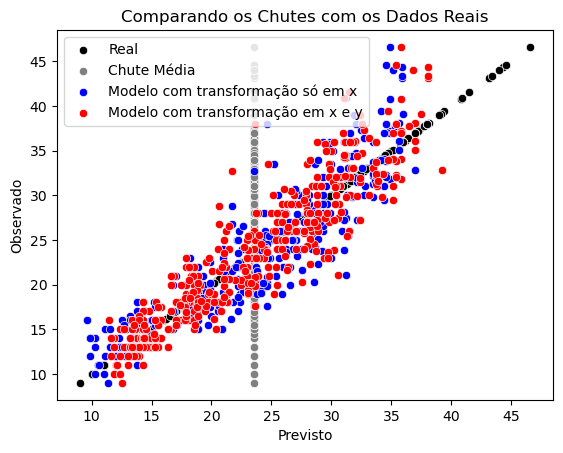

In [1733]:
# Plotando os chutes vs real

sns.scatterplot(x="mpg", y="mpg", data=tentativas, color="black", label="Real")
sns.scatterplot(x="chute_media", y="mpg", data=tentativas, color="gray", label="Chute Média")
sns.scatterplot(x=tentativas["chute_modelo_x"], y="mpg", data=tentativas, color="blue", label="Modelo com transformação só em x")
sns.scatterplot(x=tentativas["chute_modelo_xy"], y="mpg", data=tentativas, color="red", label="Modelo com transformação em x e y")

plt.title("Comparando os Chutes com os Dados Reais")
plt.xlabel("Previsto")
plt.ylabel("Observado")
plt.legend()
plt.show()

<code style="color:green">Testando se todas as variáveis utilizadas são significativas</code>

In [1734]:
# Filtra as variáveis com P>|t| > 0.05
insignificant_vars = model_transf_xy.pvalues[model_transf_xy.pvalues > 0.05].sort_values()

# Exibe as variáveis significativas e seus p-valores
insignificant_vars_tvalue = list(insignificant_vars.index)
insignificant_vars_tvalue

[]

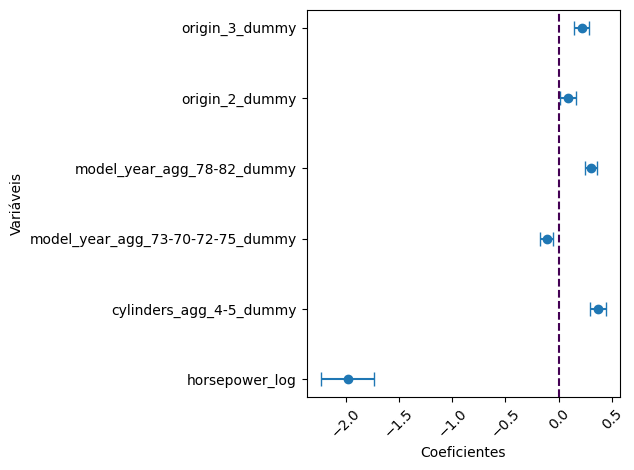

In [1735]:
# pegando o intervalo de confiança dos coeficientes menos o B0
intervalo_confianca = model_transf_xy.conf_int(alpha=0.05)[1:]

# criando o gráfico para o intervalo de confiança
fig, ax = plt.subplots()

ax.errorbar(model_transf_xy.params.drop(['const']), # pegando os valores dos coeficientes e retirando a constante
            model_transf_xy.params.drop(['const']).index,  # pegando os nomes dos coeficientes e retirando a constante
            xerr=[model_transf_xy.params.drop(['const']) - intervalo_confianca[0], # criando as barras dos intervalos (limite inferior)
                  intervalo_confianca[1] - model_transf_xy.params.drop(['const'])], # criando as barras dos intervalos (limite superior)
            fmt='o', capsize=5)

ax.set_xlabel('Coeficientes') # adicionando o rótulo do eixo x
ax.set_ylabel('Variáveis') # adicionando o rótulo do eixo y
ax.axvline(x=0,linestyle='--', color = "#440154FF") # criando uma linha vertical no x = 0
plt.xticks(rotation=45) # adicionando uma rotação de 45 graus nos valores de x
plt.tight_layout()
plt.show()

#### <code style="color:green">Análise de resíduos</code>

Pressupostos do resíduo:

1. **Normalidade**: Os resíduos precisam seguir uma distribuição normal com média igual a 0. Para avaliar isso usa-se o QQ-Plot e teste estatístico.

2. **Homogeneidade de variâncias**

3. **Independência**: Os resíduos não podem apresentar nenhum padrão conforme a variação de ychapeu
   
4. **Homocedasticidade**

<code style="color:green">Teste de Normalidade</code>

- **Shapiro-Wilk**: Testa a normalidade dos resíduos:
	- Usando quando o tamanho da amostra 4 <= n <= 2.000.
- **Kolmogorov-Smirnov (KS)**: Compara a distribuição dos resíduos com uma normal
	- Usando quando o tamanho da amostra for n > 30.

- $H_{0}:$ Os resíduos são normais
- $H_{1}:$ Os resíduos não são normais

In [1736]:
# Extrair os resíduos do modelo
residuos = model_transf_xy.resid

In [1737]:
# Teste Shapiro-Wilk

stat, p_value = shapiro(residuos)
print(f"Shapiro-Wilk: Estatística = {stat}, p-valor = {p_value}, normalidade = {p_value > 0.05}")

Shapiro-Wilk: Estatística = 0.9949376824344427, p-valor = 0.21801136095977552, normalidade = True


In [1738]:
'''# Teste KS para modelo com transformação de x e y
stat, p_value = kstest(residuos, 'norm')
print(f"KS: Estatística = {stat}, p-valor = {p_value}, normal = {p_value > 0.05}")'''

'# Teste KS para modelo com transformação de x e y\nstat, p_value = kstest(residuos, \'norm\')\nprint(f"KS: Estatística = {stat}, p-valor = {p_value}, normal = {p_value > 0.05}")'

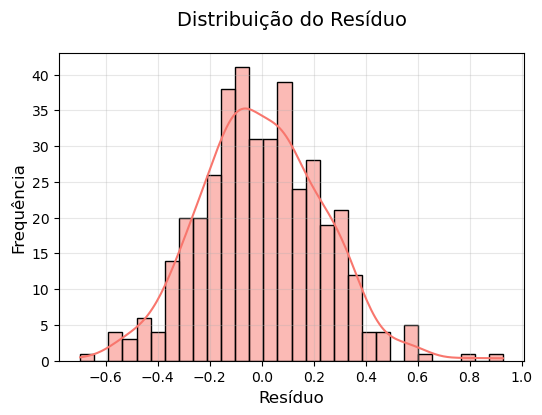

In [1739]:
# Histograma
plt.figure(figsize=(6, 4))
sns.histplot(residuos, kde=True, color='#F8766D', bins=30)
plt.xlabel('Resíduo', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Distribuição do Resíduo', fontsize=14, pad=20)
plt.grid(alpha=0.3)
plt.show()

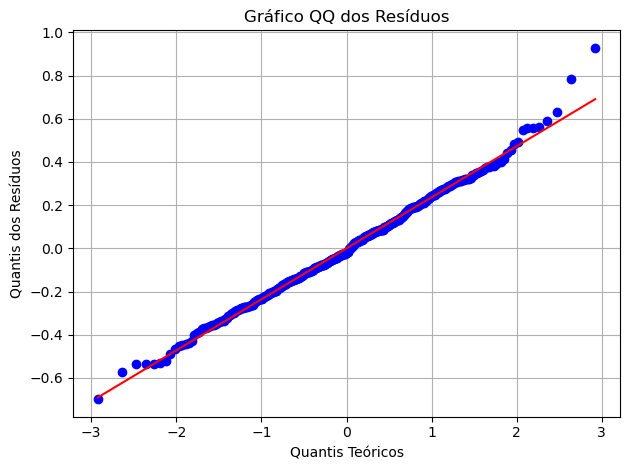

In [1740]:
# Criar o gráfico QQ para os resíduos
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Gráfico QQ dos Resíduos")
plt.xlabel("Quantis Teóricos")
plt.ylabel("Quantis dos Resíduos")
plt.grid(True)
plt.tight_layout()
plt.show()

<code style="color:green">Homocedasticidade</code>

Aplicando o teste de Breusch-Pagan:

- $H_{0}:$ Os resíduos possuem homogeneidade nas variâncias
- $H_{1}:$ Os resíduos não possuem homogeneidade nas variâncias

In [1741]:
# Realizando o teste de Breusch-Pagan para verificar heterocedasticidade para o modelo
teste_bp = het_breuschpagan(model_transf_xy.resid, model_transf_xy.model.exog)
# Definindo os rótulos para os resultados do teste
rotulos = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
# Usando zip para associar cada rótulo ao seu respectivo resultado do teste e convertendo em um dicionário
resultado_bp = dict(zip(rotulos, teste_bp))
# Exibindo o p-valor do LM-Test
print(f"Teste de Breusch-Pagan:{resultado_bp['LM-Test p-value']:.4f}, homocedástico = {resultado_bp['LM-Test p-value'] > 0.05}")

Teste de Breusch-Pagan:0.0023, homocedástico = False


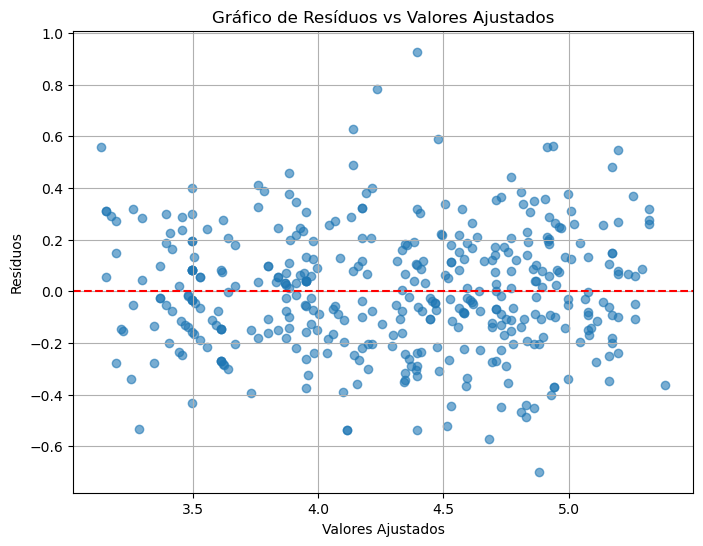

In [1742]:
# Criar o gráfico de Resíduo x Ajustado

fitted_values = model_transf_xy.fittedvalues
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuos, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')  # Linha horizontal em y = 0
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.title("Gráfico de Resíduos vs Valores Ajustados")
plt.grid(True)
plt.show()

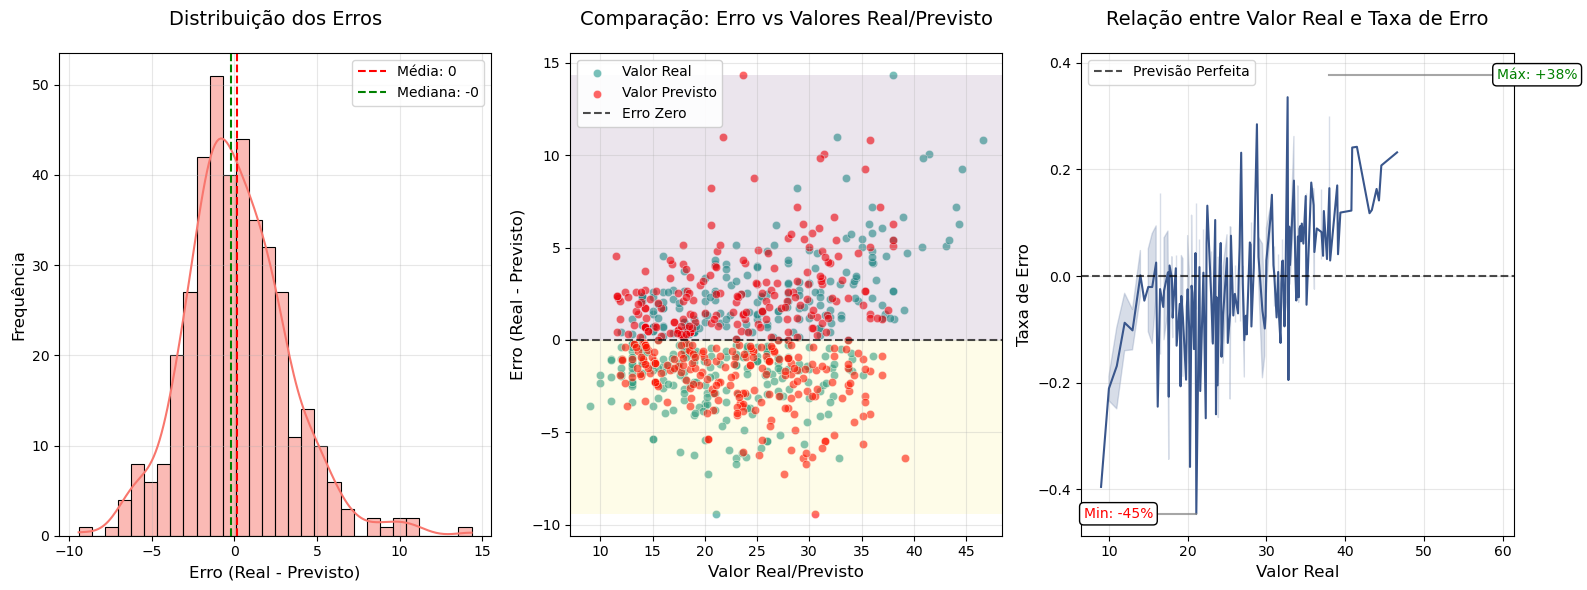

In [1743]:
# Definindo valores reais e previstos
real = df_dinamic['mpg']
previsto = df_dinamic['ychapeu_xy']

# Calculando o erro
error = real - previsto
error_rate = (error / real)

# Encontrando os pontos mínimo e máximo
min_rate = error_rate.min() # Taxa de erro mínima
max_rate = error_rate.max() # Taxa de erro máxima
min_pos = real[error_rate.idxmin()] # Valores reais correspondentes ao mínimo
max_pos = real[error_rate.idxmax()] # Valores reais correspondentes ao máximo

# Calculando as variações percentuais
max_percent = (max_rate) * 100 # Percentual máximo
min_percent = (min_rate) * 100 # Percentual mínimo

# Criando a figura com 4 subplots em 2x2
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# --- Gráfico 1: Distribuição dos Erros ---
sns.histplot(error, kde=True, color='#F8766D', bins=30, ax=ax1)
ax1.set_xlabel('Erro (Real - Previsto)', fontsize=12)
ax1.set_ylabel('Frequência', fontsize=12)
ax1.set_title('Distribuição dos Erros', fontsize=14, pad=20)
ax1.axvline(error.mean(), linestyle='--', color='red', label=f'Média: {error.mean():,.0f}')
ax1.axvline(error.median(), linestyle='--', color='green', label=f'Mediana: {error.median():,.0f}')
ax1.legend()
ax1.grid(alpha=0.3)

'''# --- Gráfico 2: Erro vs Valor Real ---
sns.scatterplot(y=error, x=real, alpha=0.6, color='#1F968BFF', ax=ax2)
ax2.axhline(0, linestyle='--', color='black', alpha=0.7, label='Erro Zero')
ax2.axhspan(ymin=0, ymax=min(error), facecolor='#FDE725FF', alpha=0.1, label='Superestimou y')
ax2.axhspan(ymin=max(error), ymax=0, facecolor='#440154FF', alpha=0.1, label='Subestimou y')
ax2.set_ylabel('Erro (Real - Previsto) (R$)', fontsize=12)
ax2.set_xlabel('Valor Real', fontsize=12)
ax2.set_title('Padrão do Valor Real em função do Erro', fontsize=14, pad=20)
ax2.legend(fontsize=10, framealpha=0.9)
ax2.grid(alpha=0.3)'''

# --- Gráfico 2: Valor Previsto vs Erro ---
sns.scatterplot(y=error, x=real, alpha=0.6, color='#1F968BFF', label='Valor Real', ax=ax2)
sns.scatterplot(y=error, x=previsto, alpha=0.6, color='red', label='Valor Previsto', ax=ax2)
ax2.axhline(0, linestyle='--', color='black', alpha=0.7, label='Erro Zero')
ax2.axhspan(ymin=0, ymax=min(error), facecolor='#FDE725FF', alpha=0.1)
ax2.axhspan(ymin=max(error), ymax=0, facecolor='#440154FF', alpha=0.1)
ax2.set_ylabel('Erro (Real - Previsto)', fontsize=12)
ax2.set_xlabel('Valor Real/Previsto', fontsize=12)
ax2.set_title('Comparação: Erro vs Valores Real/Previsto', fontsize=14, pad=20)
ax2.legend(fontsize=10, framealpha=0.9)
ax2.grid(alpha=0.3)

# --- Gráfico 3: Taxa de Erro vs Valor Real ---
sns.lineplot(x=real, y=error_rate, color='#39568CFF', linewidth=1.5, alpha=1, ax=ax3)
ax3.axhline(0, linestyle='--', color='black', alpha=0.7, label='Previsão Perfeita')

# Configurações do frame (bbox)
bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", linewidth=1)

# --- TAG DO MÁXIMO (DIREITA) ---
max_text = f'Máx: +{max_percent:.0f}%' if max_percent > 0 else f'{max_percent:.0f}%'
ax3.plot([max_pos, max_pos*1.55], [max_rate, max_rate], color='gray', linestyle='-', alpha=0.7)
ax3.text(max_pos*1.56, max_rate, max_text, 
         va='center', ha='left', color='green', fontsize=10,
         bbox=bbox_props)

# --- TAG DO MÍNIMO (ESQUERDA) ---
min_text = f'Min: {min_percent:.0f}%'  
ax3.plot([min_pos, min_pos*0.75], [min_rate, min_rate], color='gray', linestyle='-', alpha=0.7)
ax3.text(min_pos*0.74, min_rate, min_text,
         va='center', ha='right', color='red', fontsize=10,
         bbox=bbox_props)

ax3.set_xlabel('Valor Real', fontsize=12)
ax3.set_ylabel('Taxa de Erro', fontsize=12)
ax3.set_title('Relação entre Valor Real e Taxa de Erro', fontsize=14, pad=20)
ax3.legend()
ax3.grid(alpha=0.3)

# Ajuste de layout
plt.tight_layout()
plt.show()

<code style="color:green">Multicolinearidade</code>

In [1744]:
X.drop(columns=['const']).columns

Index(['horsepower_log', 'cylinders_agg_4-5_dummy',
       'model_year_agg_73-70-72-75_dummy', 'model_year_agg_78-82_dummy',
       'origin_2_dummy', 'origin_3_dummy', 'mpg', 'chute_media',
       'chute_modelo_x', 'chute_modelo_xy', 'erro'],
      dtype='object')

In [1745]:
# criando um dataframe vazio
vif = pd.DataFrame()
# Identificando apenas colunas numéricas com final log para calcular o VIF
cols = [col for col in X.columns if col.endswith('_log')]

# para cada coluna, calcule o VIF
vif["Variáveis"] = X[cols].columns
vif["VIF"]       = [variance_inflation_factor(X[cols].values, i) for i in range(len(X[cols].columns))] 

# Criando coluna para interpretação de VIF
vif['Interpretação'] = np.where(vif['VIF'] < 5, 'Aceitável', np.where(vif['VIF'] < 10, 'Preocupante', 'Alta multicolinearidade'))
vif

ValueError: zero-size array to reduction operation maximum which has no identity

<code style="color:purple">Multicolinearidade - Comentário</code>

Como só sobrou uma variável numérica, não foi possível calcular VIF. 

# <center>OBSERVAÇÕES FINAIS

<code style="color:purple">Base de dados</code>

- Variável dependente (y): Não seguia distribuição normal, exigiu tranformação box-cox
- Variáveis independentes numéricas: Variáveis numéricas não seguiam distribuição normal. Apesar da aplicação da transformação logarítmica, ainda não seguiam distribuição normal.
- Variáveis independentes categóricas: Aplicou-se agrupamento de categorias e dummização.

<code style="color:purple">Construção do modelo</code>

- Modelos testados: Testou-se os modelos com transformações apenas em X e com transformação em X e y (box-cox).
- Seleção de variáveis: Aplicou-se seleção de variáveis manualmente, excluindo variáveis com alta correlação entre si e, posteriormente, utilizando o método backwards com p-valor.
- O modelo com tranformação box-cox performou melhor.
- Apesar de visualmente os resíduos não aparentarem seguir um padrão, o teste de Breusch-Pagan apresenta heterocedasticidade. Em uma análise gráfica mais profunda, observa-se que a taxa de erro tende a aumentar à medida que o valor real aumenta.
- Como, após a seleção manual de variáveis com base em colinearidade, manteve-se apenas uma variável numérica independente, não observa-se problemas com multicolinearidade.